In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import normflows as nf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
print(f"Using device: {device}")

/home/pgrad2/2448355h/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using device: cuda


In [2]:
def sim_revexp_u_mgpd(n, d, a, beta, sig, gamma, MGPD=True, std=False):
    lam = np.exp(beta)
    Y = np.zeros((n, d))
    C = 1 / np.min(lam)
    k = 0

    while k < n:
        U = np.random.uniform(0, 1, d)
        W = (U ** a) / lam
        R = np.random.uniform(0, C)
        
        Ind = R < np.max(W)
        
        if Ind:
            Y[k, :] = W / R
            k += 1

    if std and not MGPD:
        return np.log(Y)

    X = []
    for j in range(d):
        if gamma[j] != 0:
            X.append(sig[j] * (Y[:, j] ** gamma[j] - 1) / gamma[j])
        else:
            X.append(sig[j] * np.log(Y[:, j]))
    X = np.column_stack(X)

    if MGPD and not std:
        return X
    if std and MGPD:
        return {'X': X, 'Z': np.log(Y)}

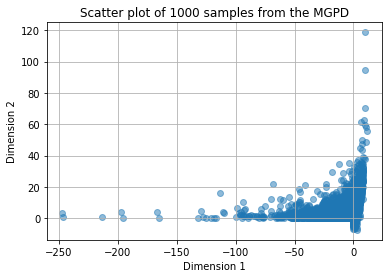

In [5]:
n_samples = 10000
d = 2
a = np.array([3,0.5])
beta = np.array([0, 0])
sig = np.array([2,3])
gamma = np.array([-0.1, 0.2])

samples = sim_revexp_u_mgpd(n_samples, d, a, beta, sig, gamma)

# Visualize the samples
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter plot of 1000 samples from the MGPD')
plt.grid(True)
plt.show()

[4.50526653 3.63615794]


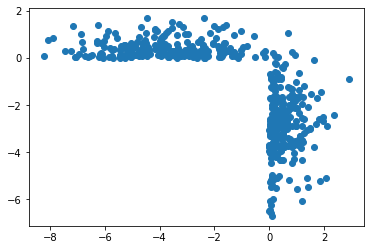

In [32]:
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups


mean = [0, 0]
cov = [[3, 0.5], [0.5, 2]] 
x, y = np.random.multivariate_normal(mean, cov, 50000).T
samples = np.stack([x,y],axis=1)
u = np.quantile(samples, 0.995,axis=0)
print(u)
samples = samples[(samples[:,0] > u[0] ) | (samples[:,1] > u[1] ),:]
u = u.reshape(1,-1)
samples = samples - u
plt.scatter(samples[:, 0], samples[:, 1], alpha=1)
# plt.xlim([0,5])
# plt.ylim([0,5])
plt.show()

In [5]:
samples.shape

(494, 2)

In [6]:
class DataTransform(nn.Module):
    """
    Elementwise transform:
      If gamma_j = 0:
        forward_transform(y_j): x_j = sigma_j * y_j
        inverse_transform(x_j): y_j = x_j / sigma_j
      Otherwise (gamma_j != 0):
        forward_transform(y_j): x_j = sigma_j * [exp(gamma_j * y_j) - 1] / gamma_j
        inverse_transform(x_j): y_j = (1 / gamma_j)* log(1 + gamma_j * x_j / sigma_j)
    """

    def __init__(self, dim, device):
        super().__init__()
        self.dim = dim
        # Store log_sigma so sigma = exp(log_sigma) > 0
        self.log_sigma = nn.Parameter(torch.zeros(dim, device=device))
        
        self.theta = nn.Parameter(torch.zeros(dim, device=device))
        
    def get_sigma(self):
        sigma = torch.exp(self.log_sigma)
        sigma = torch.clamp(sigma, min = 1e-6, max = 1e6)
        return sigma
    
    def get_gamma(self):
        gamma = -0.5 + torch.sigmoid(self.theta)  + 1e-6 
        gamma = gamma.sign() * torch.max(gamma.abs(), torch.tensor(1e-6, device=gamma.device))
        return gamma
        
    def forward_transform(self, y):
        """
        y -> x
        """
#         y = torch.clamp(y, min= -1e6, max = 1e6)
        
        sigma = self.get_sigma()
        gamma = self.get_gamma()
        
        # We'll do it elementwise, but in a vectorized way.
        # y and x are shape (batch_size, dim).
    
        x_out = torch.zeros_like(y)

        # For gamma_j = 0 => x_j = sigma_j * y_j
        # For gamma_j != 0 => x_j = sigma_j*(exp(gamma_j*y_j) - 1)/gamma_j
        # We can use torch.where(...) to handle each dimension separately.

        # Expand so shapes match for broadcasting
        sigma = sigma.unsqueeze(0)  # (1, dim)
        gamma = gamma.unsqueeze(0)  # (1, dim)

        # Exponential case: x_j = sigma_j*(exp(gamma_j*y_j) - 1)/gamma_j
        x_out = sigma * (torch.exp(torch.clamp(gamma * y, max=10)) - 1.0) / gamma
        
#         x_out = torch.clamp(x_out, min= -1e10, max = 1e10)
        return x_out

    def inverse_transform(self, x):
        """
        x -> y
        """
#         x = torch.clamp(x, min= -1e10, max = 1e10)
        
        sigma = self.get_sigma()
        gamma = self.get_gamma()

        y_out = torch.zeros_like(x)

        # For gamma_j = 0 => y_j = x_j / sigma_j
        # For gamma_j != 0 => y_j = (1/gamma_j)* log(1 + gamma_j*x_j / sigma_j)
        sigma = sigma.unsqueeze(0)  # (1, dim)
        gamma = gamma.unsqueeze(0)  # (1, dim)

#         gamma_is_zero = (gamma.abs() < 1e-6)

#         # Linear case: y_j = x_j / sigma_j
#         y_linear = x / sigma

        # Exponential (inverse) case: y_j = (1/gamma_j)* log(1 + gamma_j*x_j / sigma_j)
        inside = 1.0 + (gamma * x) / sigma
        inside = torch.clamp(inside, min=1e-12) 
        y_out = (1.0 / gamma) * torch.log(inside)

#         y_out = torch.clamp(y_out, min= -1e6, max = 1e6)
        return y_out

    def forward(self, z, reverse=False):
        """
        For normflows compatibility:
          - If reverse=False: we do y->x
          - If reverse=True: we do x->y
        """
        if not reverse:
            return self.forward_transform(z)
        else:
            return self.inverse_transform(z)

In [7]:
class T_mGPD_NF(nn.Module):
    """
    Interpreting:
       x = observed data (size=dim)
       y = standardized data
    We have:

      DataTransform.forward_transform(y)   = x
      DataTransform.inverse_transform(x)   = y

    So in 'forward(x)', to get minus log-likelihood of data x:
       1) We do y = inverse_transform(x)
       2) log_p_flow(y) = flow_model.log_prob(y)
       3) The log-det Jacobian of x->y is the sum of log(d y_i / d x_i).
          We'll compute that from the known formula for inverse_transform.
    """
    def __init__(self, dim, flow, device, s_min , s_max, num_integration_points, penalty_lambda):
        super().__init__()
        self.dim = dim
        # Learnable data transformation
        self.data_transform = DataTransform(dim, device)
        # RealNVP flow model
        self.flow_model = flow
        self.device = device
        self.s_values = torch.linspace(s_min, s_max, num_integration_points, device=device)
        self.s_values = self.s_values.reshape(-1, 1, 1)
        self.s_min = s_min
        self.s_max = s_max
        self.num_integration_points = num_integration_points
        self.penalty_lambda = penalty_lambda
        
    def log_integral_f_T(self, data):
            # Expand batch_x to match s_values
        batch_size = data.shape[0]
        dim = data.shape[1]
        
        x_expanded = data.unsqueeze(0)  # Shape (1, effective_batch_size, dim)
        x_expanded = x_expanded.expand(self.num_integration_points, -1, -1)  # Shape (num_points, batch_size, dim)

        # Expand s_values to match batch size and dimension
        s_expanded = self.s_values.expand(-1, batch_size, 1)  # Shape (num_points, batch_size, 1)

        # Compute x + s for all s_values
        x_plus_s = x_expanded + s_expanded  # Broadcasting over the last dimension
        x_plus_s = x_plus_s.reshape(-1, dim)  # Flatten to (num_points * batch_size, dim)

        log_f_T = self.flow_model.log_prob(x_plus_s)  # Shape (num_points * batch_size,)
        log_integrand = log_f_T.reshape(self.num_integration_points, batch_size)
        
        # 1. log-sum-exp over 'num_points' dimension
        max_vals, _ = torch.max(log_integrand, dim=0, keepdim=True)  # shape (1, batch_size)
        stable_exp = torch.exp(log_integrand - max_vals)             # shape (num_points, batch_size)
        
        delta_s = (self.s_max - self.s_min) / (self.num_integration_points - 1)
        sum_exp = torch.trapz(stable_exp, dx=delta_s, dim=0)         # shape (batch_size,)
        # 2. Now put the max_vals back in:
        log_integral = max_vals.squeeze(0) + torch.log(sum_exp + 1e-40)  # shape (batch_size,)
        
        return log_integral
    
    def log_prob_T_mGPD_std(self, data):
        log_integral = self.log_integral_f_T(data)
        max_T = torch.max(data, dim=1)[0]
        
        log_prob = log_integral - max_T
        return log_prob
    
    
        

    def forward(self, x_data):
        """
        Return minus log p_data(x_data).
        We do:
          y = T_inv(x_data)  [since T_inv is x->y]
          log p_data(x_data) = log p_flow(y) + log|det(d y / d x)|
        """
        # 1) x->y
        y = self.data_transform.inverse_transform(x_data)

        # 2) log prob under flow
        log_prob_y = self.log_prob_T_mGPD_std(y)

        # 3) log | det dy/dx
        sigma = self.data_transform.get_sigma()
        gamma = self.data_transform.get_gamma()

        sigma = sigma.unsqueeze(0)  # (1, dim)
        gamma = gamma.unsqueeze(0)  # (1, dim)

        # Build inside = sigma + gamma*x
        inside = sigma + gamma * x_data

        # log_abs_detJ per sample = - sum_j log(inside_j)
        log_abs_detJ = -torch.sum(torch.log(inside.abs() + 1e-12), dim=1)
        
        # => log p(x_data) = log p(y) + log|det dy/dx|
        log_prob_x = log_prob_y + log_abs_detJ
        
        ######## Soft penalty: penalize negative (sigma_j + gamma_j*x_j)
        negative_part = torch.relu(-inside)  # = max(0, -(inside)) => positive if inside<0
        # penalty = sum_j [ negative_part^2 ] over j, average over batch
        penalty_per_sample = (negative_part ** 2).sum(dim=1)
        penalty = self.penalty_lambda * penalty_per_sample.mean()
        
        return -log_prob_x.mean() +  penalty 

    def sample(self, n_samples=1):
        """
        Sample from the learned distribution in x-space by:
          1) Sample y ~ flow
          2) Convert y->x using forward_transform
        """
        self.flow_model.eval()
        samples_T,_ = self.flow_model.sample(n_samples)
        self.flow_model.train()
        
        samples_T_max = torch.max(samples_T,axis=1,keepdim=True)[0]
        samples_T_1 = samples_T - samples_T_max
        
        samples_E  = torch.empty(n_samples, device=self.device)
        samples_E = samples_E.exponential_(1.0).unsqueeze(1)
        
        samples_y = samples_E + samples_T_1

        samples_x = self.data_transform.forward_transform(samples_y)  # y->x
        return samples_x, samples_y, samples_T



In [33]:
data = torch.tensor(samples, dtype=torch.float, device = device)

In [9]:
memory = torch.cuda.memory_allocated(device) /10**9
print('{:.2f}G GPU memory allocated'.format(memory))

0.00G GPU memory allocated


In [87]:
dim = 2
base = nf.distributions.base.DiagGaussian(2)

num_layers = 4
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 10, 10, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))
    
f_T_model = nf.NormalizingFlow(base, flows)
f_T_model = f_T_model.to(device)


batch_size = 64
loss_history = []
n_samples = 10000
epochs = 100

model = T_mGPD_NF(dim=2, flow =f_T_model, device=device, s_min=-10,
                  s_max = 10, num_integration_points=1000, penalty_lambda=50000)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-5)
optimizer = torch.optim.Adam([
    {'params': model.flow_model.parameters(), 'lr': 5e-4},  # Flow layers
    {'params': model.data_transform.log_sigma, 'lr': 5e-3},  # Faster for log_sigma
    {'params': model.data_transform.theta, 'lr': 5e-3}       # Faster for gamma
])
# for name, param in model.named_parameters():
#     print(name, param)



Epoch 1/100, Loss: 1.0024
Epoch 0 - Learning Rate: 0.0005


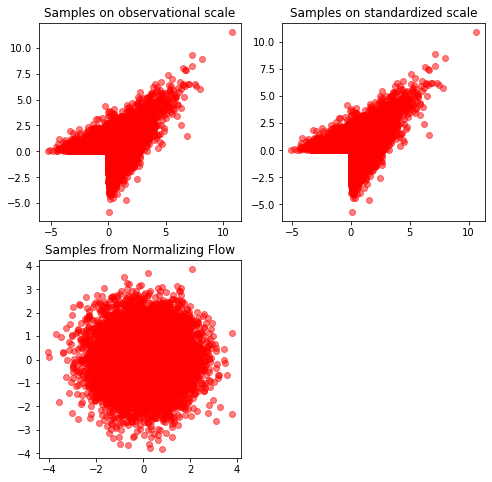

Epoch 2/100, Loss: 0.9236
Epoch 1 - Learning Rate: 0.0004998766400914329


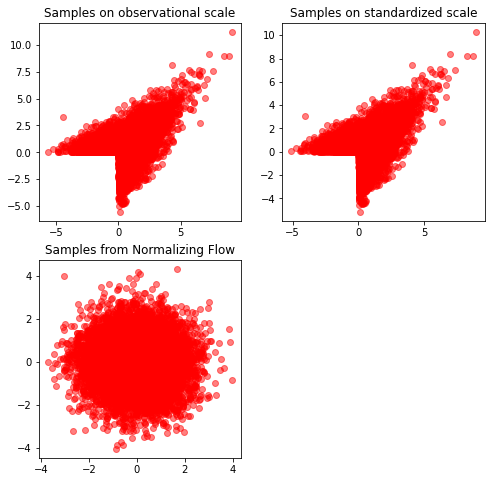

Epoch 3/100, Loss: 0.8521
Epoch 2 - Learning Rate: 0.0004995066821070679


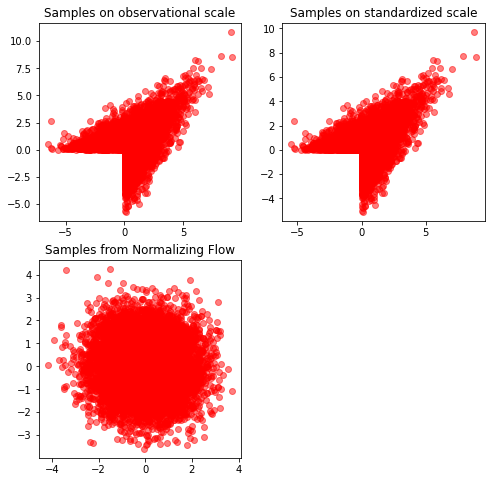

Epoch 4/100, Loss: 0.7895
Epoch 3 - Learning Rate: 0.00049889049115077


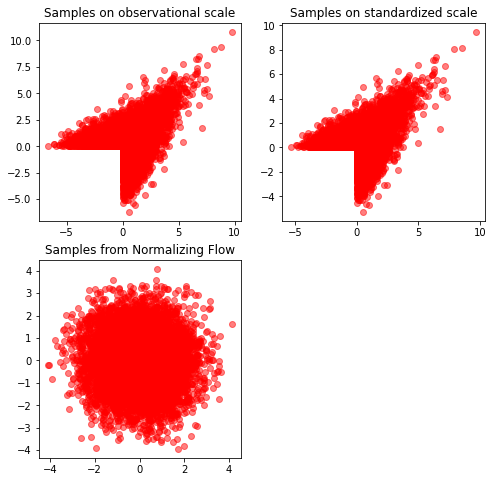

Epoch 5/100, Loss: 0.7433
Epoch 4 - Learning Rate: 0.0004980286753286195


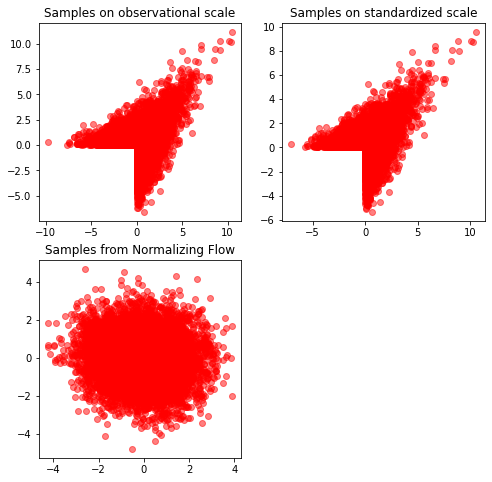

Epoch 6/100, Loss: 0.7078
Epoch 5 - Learning Rate: 0.0004969220851487844


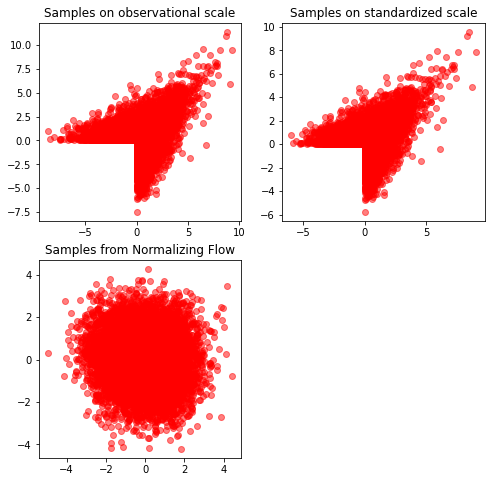

Epoch 7/100, Loss: 0.6774
Epoch 6 - Learning Rate: 0.0004955718126821722


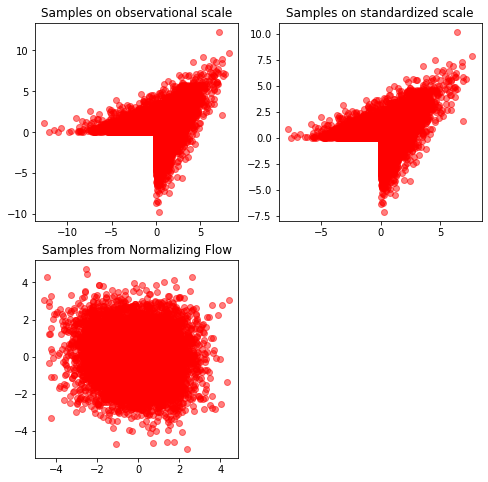

Epoch 8/100, Loss: 0.6583
Epoch 7 - Learning Rate: 0.0004939791904846868


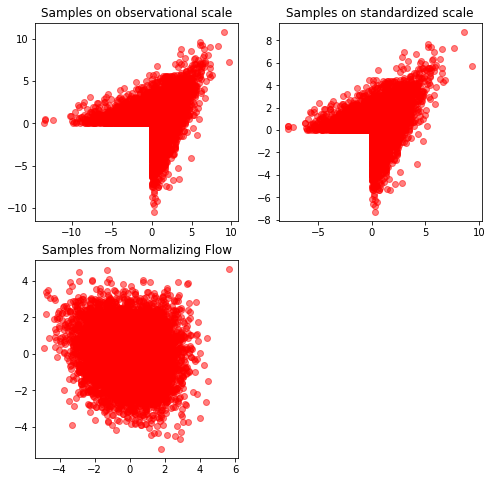

Epoch 9/100, Loss: 0.6443
Epoch 8 - Learning Rate: 0.0004921457902821577


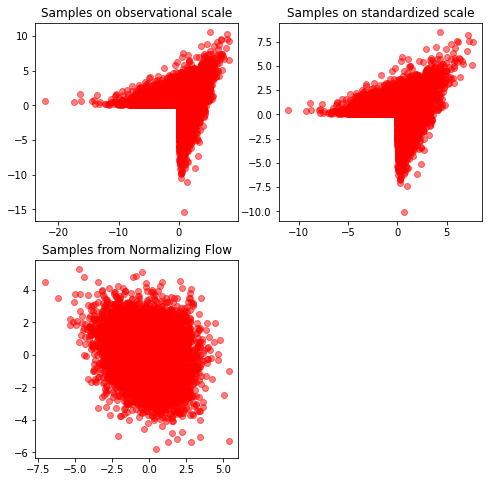

Epoch 10/100, Loss: 0.6339
Epoch 9 - Learning Rate: 0.0004900734214192357


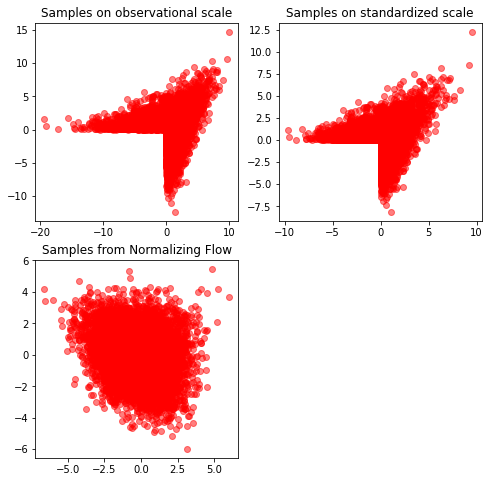

Epoch 11/100, Loss: 0.6268
Epoch 10 - Learning Rate: 0.00048776412907378835


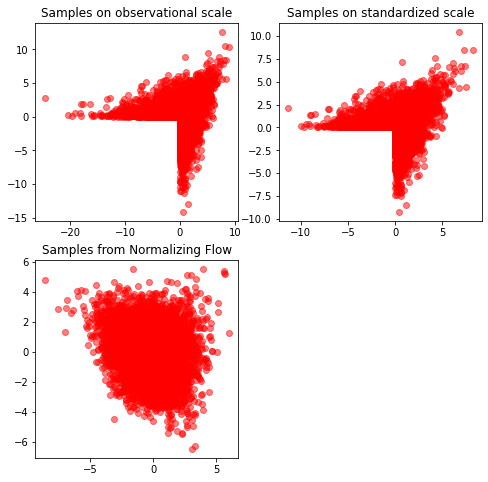

Epoch 12/100, Loss: 0.6206
Epoch 11 - Learning Rate: 0.00048522019223855637


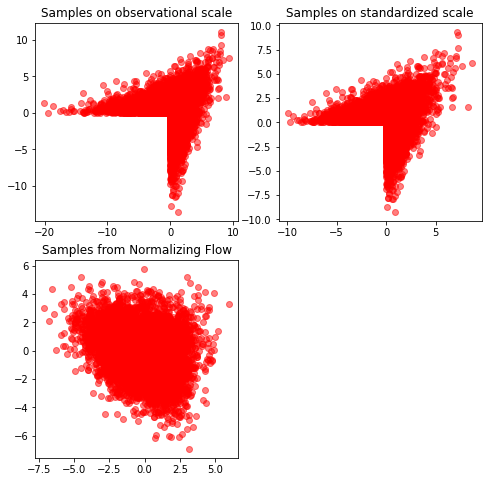

Epoch 13/100, Loss: 0.6146
Epoch 12 - Learning Rate: 0.00048244412147206283


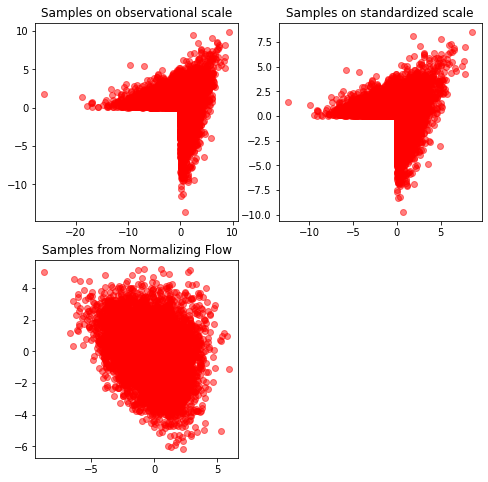

Epoch 14/100, Loss: 0.6073
Epoch 13 - Learning Rate: 0.00047943865642099525


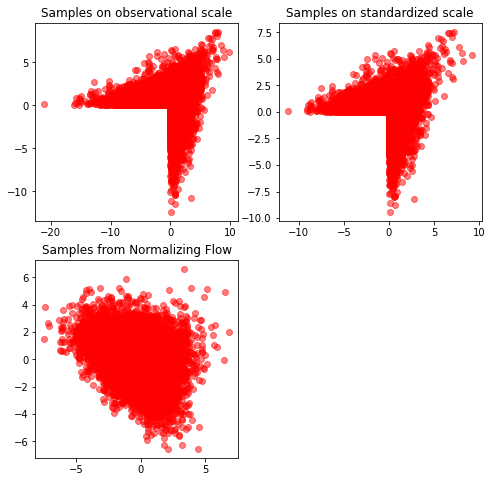

Epoch 15/100, Loss: 0.6008
Epoch 14 - Learning Rate: 0.0004762067631165049


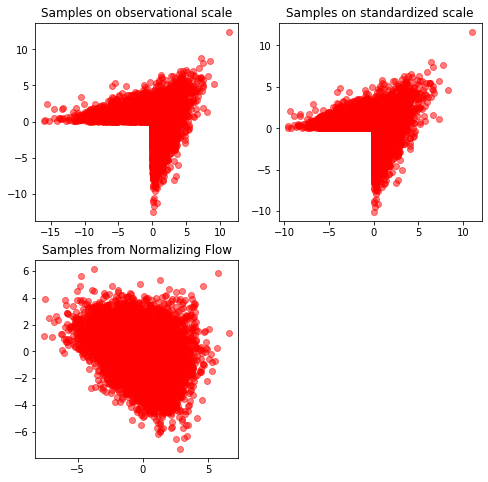

Epoch 16/100, Loss: 0.5950
Epoch 15 - Learning Rate: 0.00047275163104709196


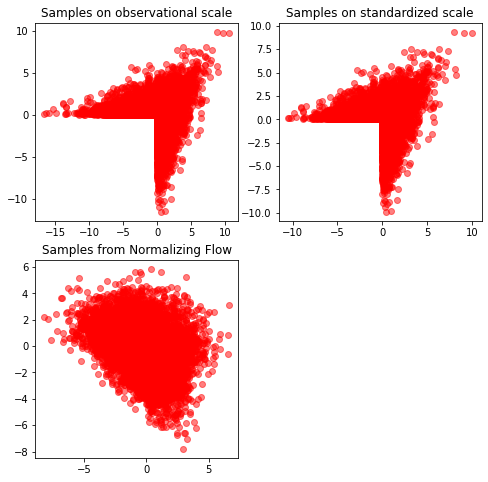

Epoch 17/100, Loss: 0.5893
Epoch 16 - Learning Rate: 0.0004690766700109659


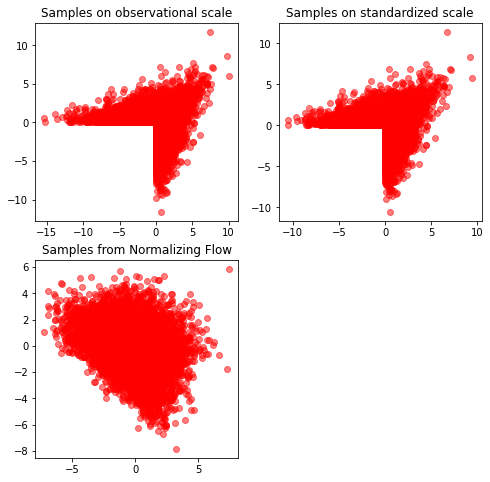

Epoch 18/100, Loss: 0.5822
Epoch 17 - Learning Rate: 0.00046518550675098597


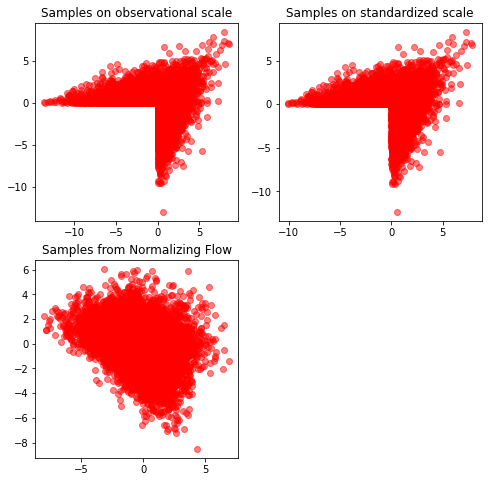

Epoch 19/100, Loss: 0.5752
Epoch 18 - Learning Rate: 0.0004610819813755038


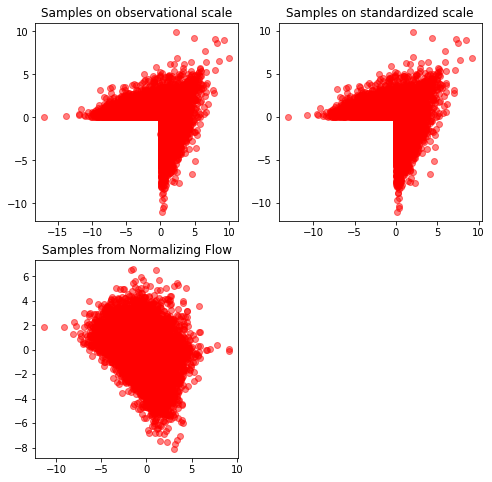

Epoch 20/100, Loss: 0.5697
Epoch 19 - Learning Rate: 0.0004567701435686405


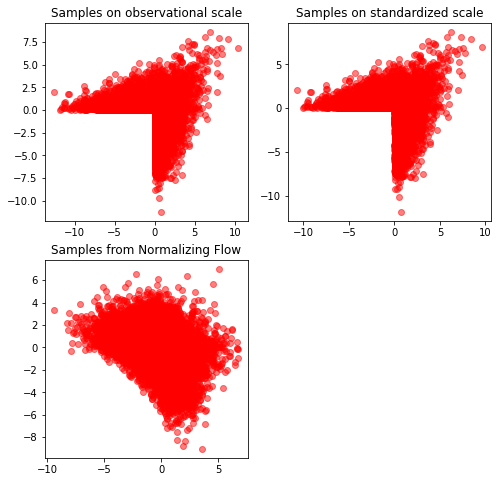

Epoch 21/100, Loss: 0.5642
Epoch 20 - Learning Rate: 0.00045225424859373693


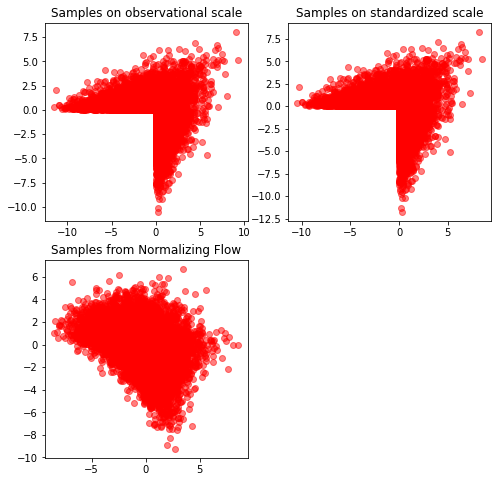

Epoch 22/100, Loss: 0.5592
Epoch 21 - Learning Rate: 0.0004475387530939226


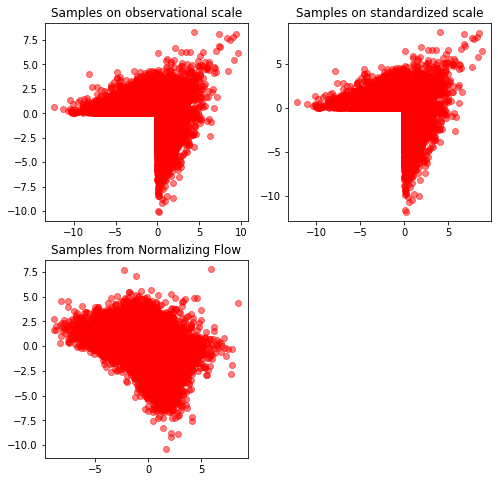

Epoch 23/100, Loss: 0.5527
Epoch 22 - Learning Rate: 0.0004426283106939473


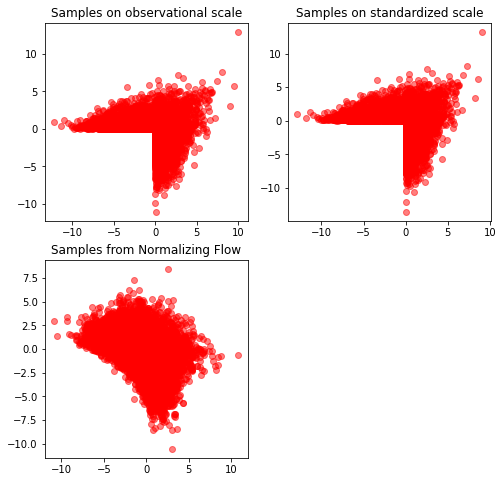

Epoch 24/100, Loss: 0.5494
Epoch 23 - Learning Rate: 0.0004375277674076149


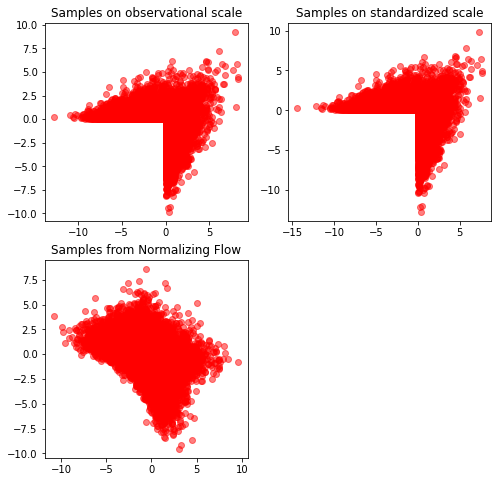

Epoch 25/100, Loss: 0.5457
Epoch 24 - Learning Rate: 0.00043224215685535287


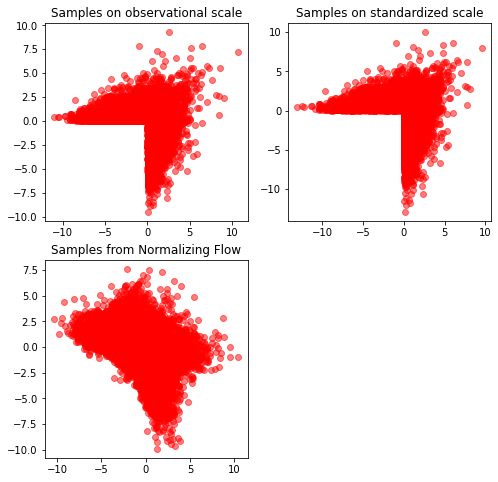

Epoch 26/100, Loss: 0.5413
Epoch 25 - Learning Rate: 0.00042677669529663686


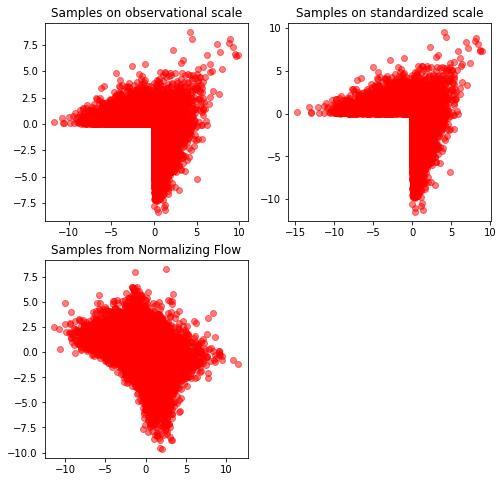

Epoch 27/100, Loss: 0.5362
Epoch 26 - Learning Rate: 0.0004211367764821722


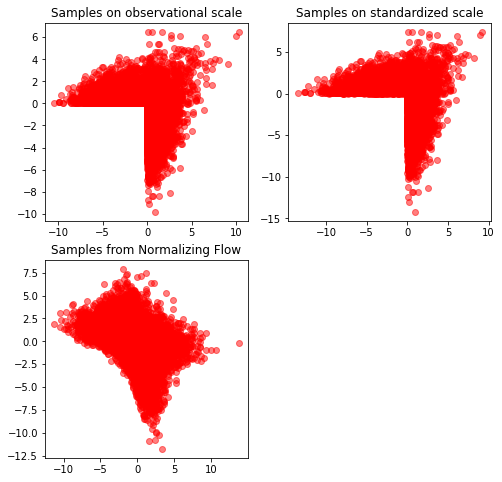

Epoch 28/100, Loss: 0.5331
Epoch 27 - Learning Rate: 0.00041532796633091297


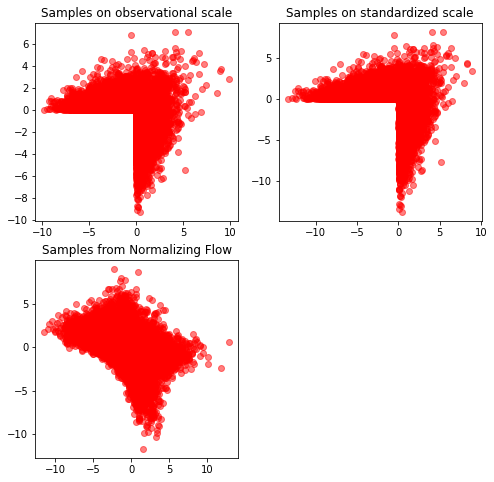

Epoch 29/100, Loss: 0.5311
Epoch 28 - Learning Rate: 0.00040935599743717243


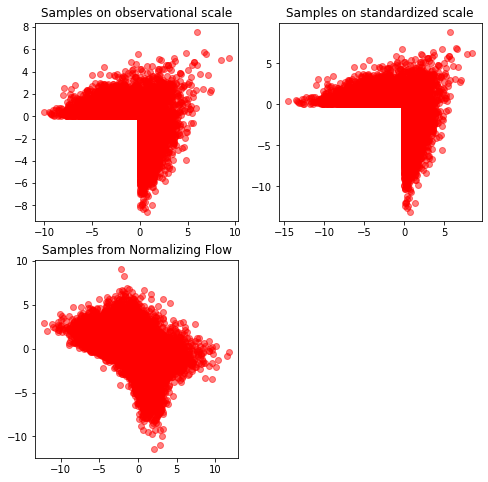

Epoch 30/100, Loss: 0.5270
Epoch 29 - Learning Rate: 0.00040322676341324415


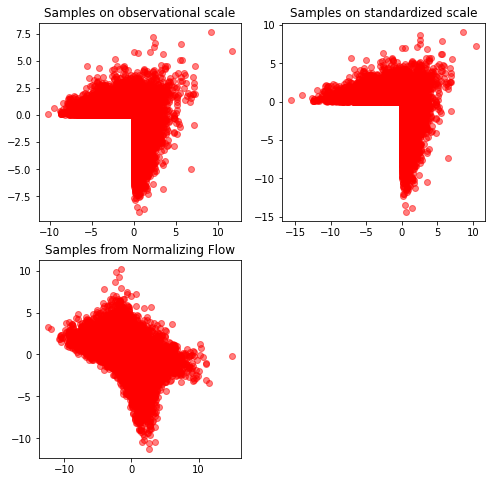

Epoch 31/100, Loss: 0.5248
Epoch 30 - Learning Rate: 0.00039694631307311834


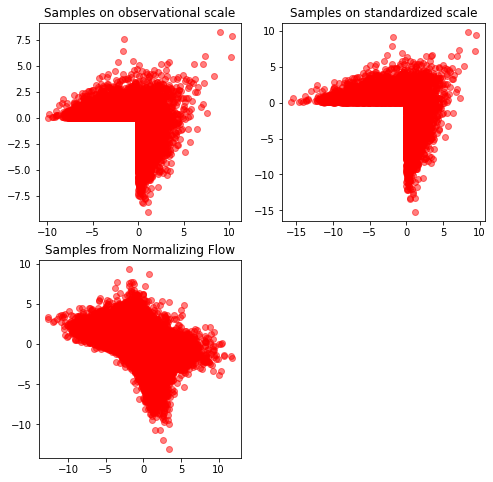

Epoch 32/100, Loss: 0.5235
Epoch 31 - Learning Rate: 0.0003905208444630327


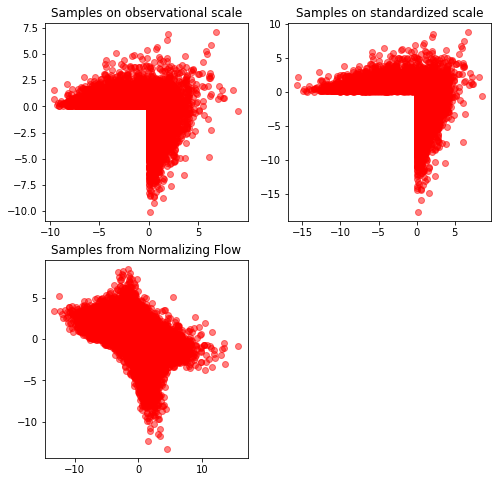

Epoch 33/100, Loss: 0.5209
Epoch 32 - Learning Rate: 0.00038395669874474915


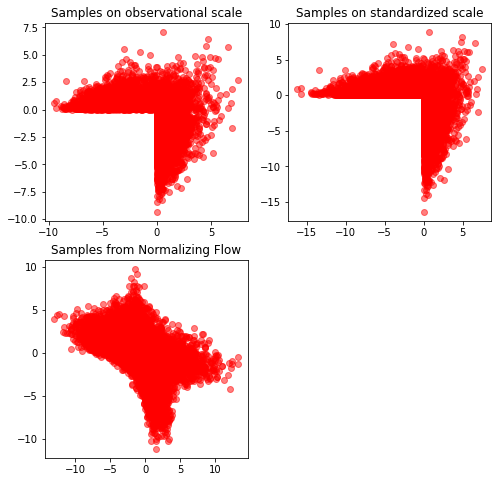

Epoch 34/100, Loss: 0.5190
Epoch 33 - Learning Rate: 0.00037726035393759286


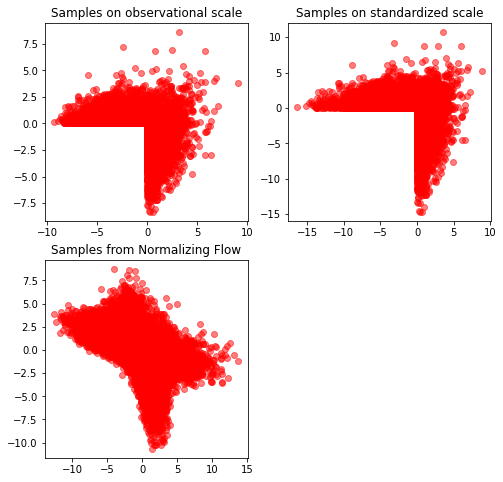

Epoch 35/100, Loss: 0.5170
Epoch 34 - Learning Rate: 0.00037043841852542884


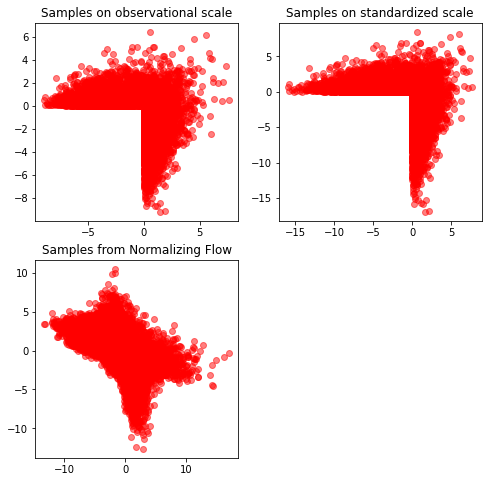

Epoch 36/100, Loss: 0.5139
Epoch 35 - Learning Rate: 0.0003634976249348867


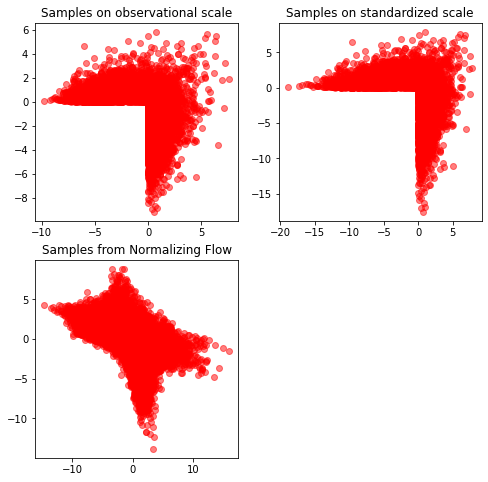

Epoch 37/100, Loss: 0.5128
Epoch 36 - Learning Rate: 0.0003564448228912682


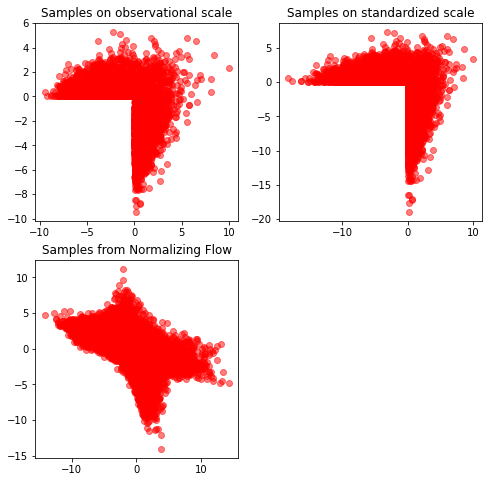

Epoch 38/100, Loss: 0.5125
Epoch 37 - Learning Rate: 0.00034928697265869515


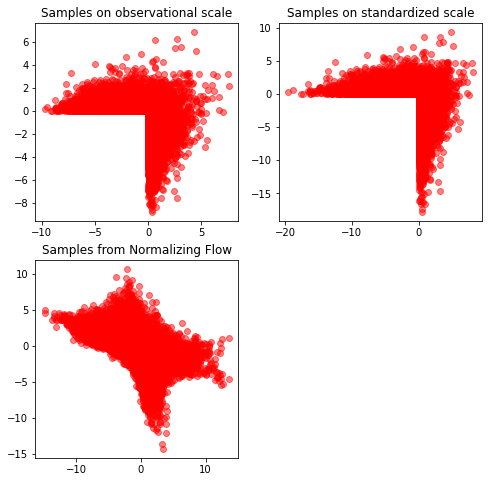

Epoch 39/100, Loss: 0.5109
Epoch 38 - Learning Rate: 0.00034203113817116957


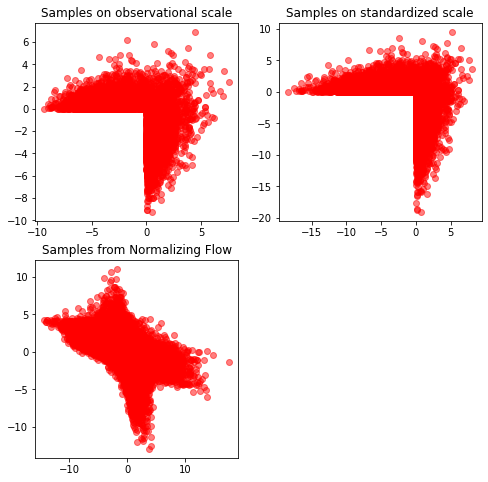

Epoch 40/100, Loss: 0.5083
Epoch 39 - Learning Rate: 0.0003346844800613229


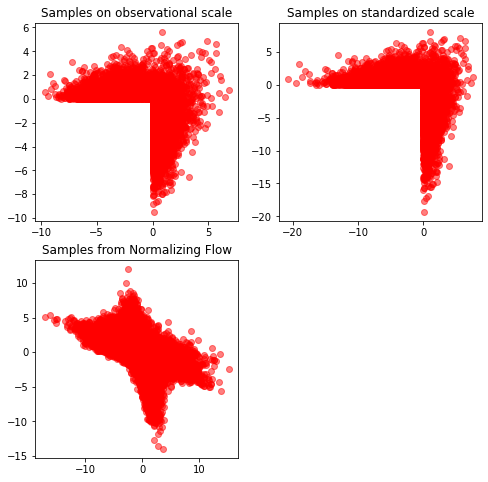

Epoch 41/100, Loss: 0.5078
Epoch 40 - Learning Rate: 0.00032725424859373687


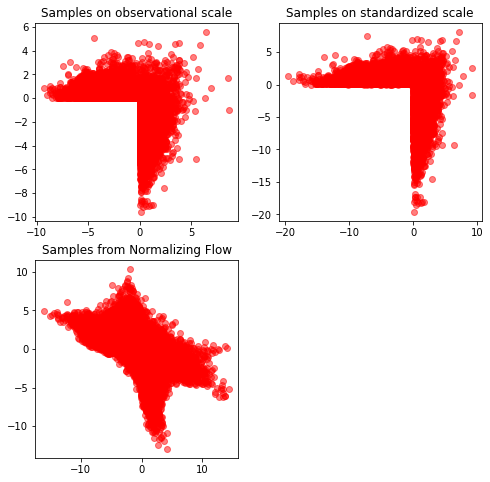

Epoch 42/100, Loss: 0.5056
Epoch 41 - Learning Rate: 0.00031974777650980735


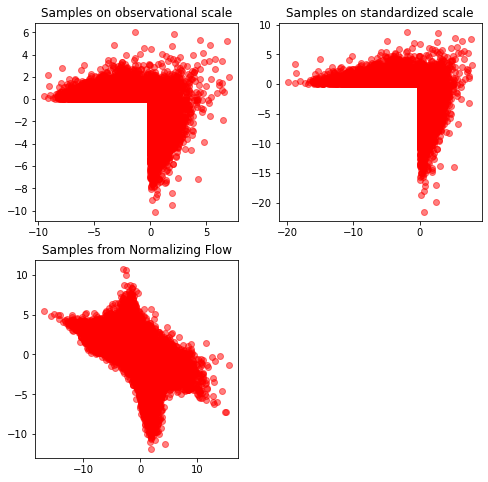

Epoch 43/100, Loss: 0.5047
Epoch 42 - Learning Rate: 0.0003121724717912137


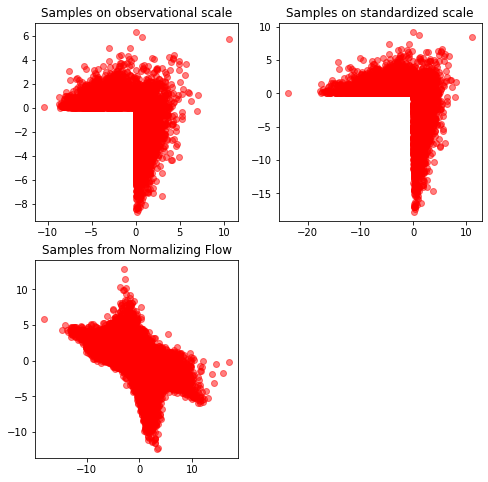

Epoch 44/100, Loss: 0.5053
Epoch 43 - Learning Rate: 0.0003045358103491357


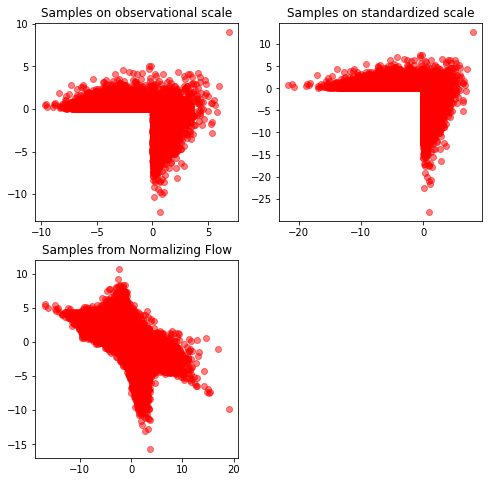

Epoch 45/100, Loss: 0.5037
Epoch 44 - Learning Rate: 0.00029684532864643126


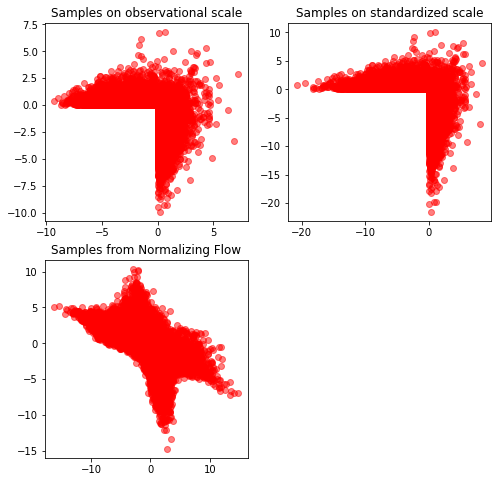

Epoch 46/100, Loss: 0.5030
Epoch 45 - Learning Rate: 0.0002891086162600578


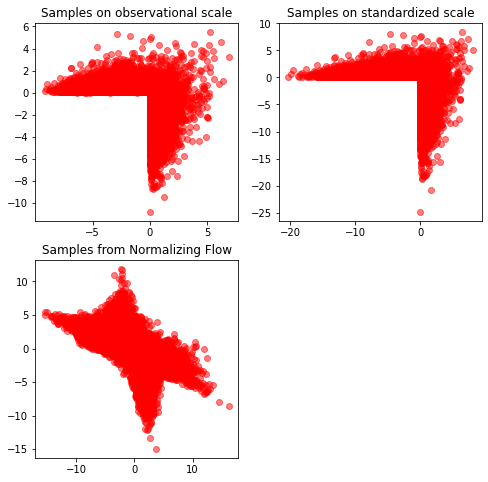

Epoch 47/100, Loss: 0.5024
Epoch 46 - Learning Rate: 0.00028133330839107617


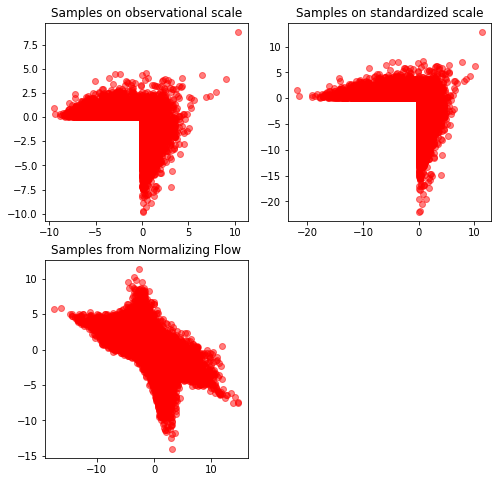

Epoch 48/100, Loss: 0.5014
Epoch 47 - Learning Rate: 0.0002735270783296286


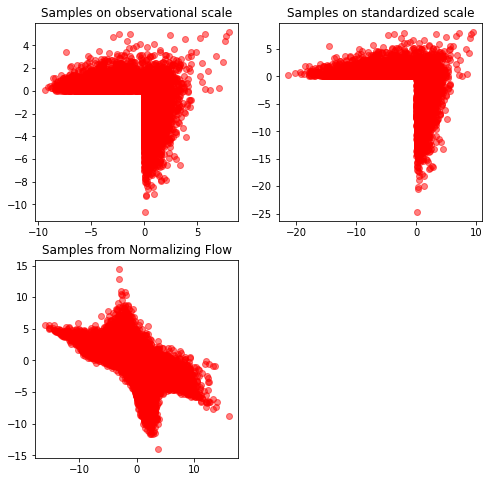

Epoch 49/100, Loss: 0.5007
Epoch 48 - Learning Rate: 0.00026569762988232844


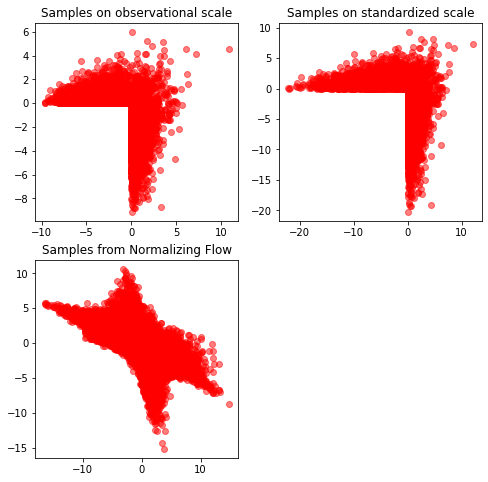

Epoch 50/100, Loss: 0.5001
Epoch 49 - Learning Rate: 0.00025785268976953217


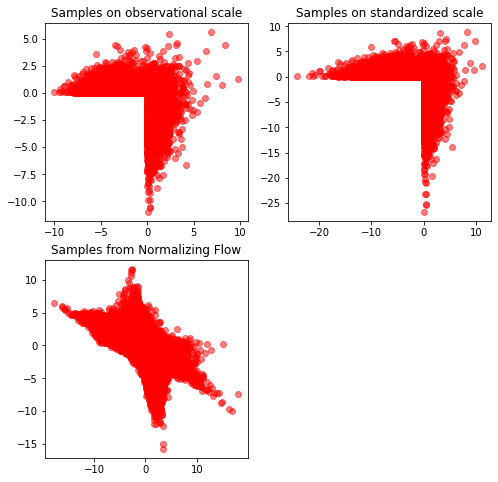

Epoch 51/100, Loss: 0.5009
Epoch 50 - Learning Rate: 0.0002500000000000001


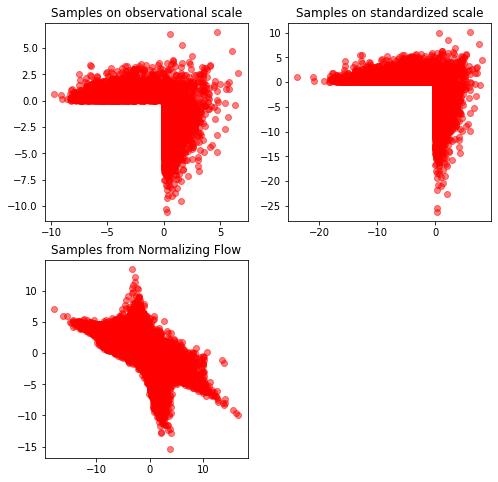

Epoch 52/100, Loss: 0.4999
Epoch 51 - Learning Rate: 0.00024214731023046803


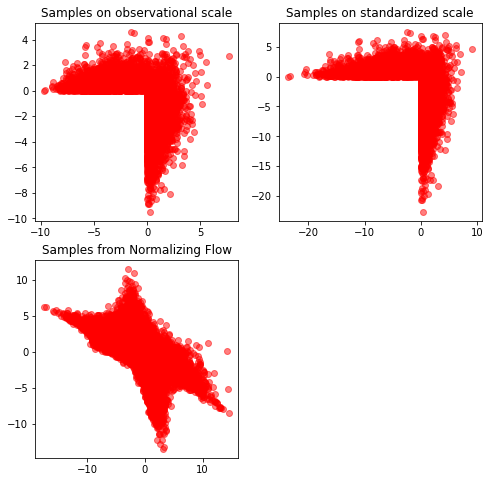

Epoch 53/100, Loss: 0.5003
Epoch 52 - Learning Rate: 0.00023430237011767176


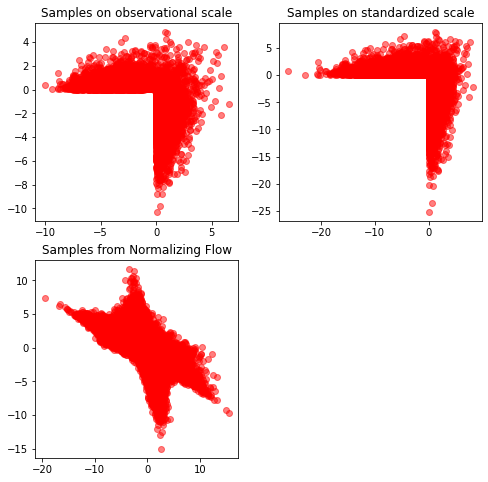

Epoch 54/100, Loss: 0.4991
Epoch 53 - Learning Rate: 0.0002264729216703715


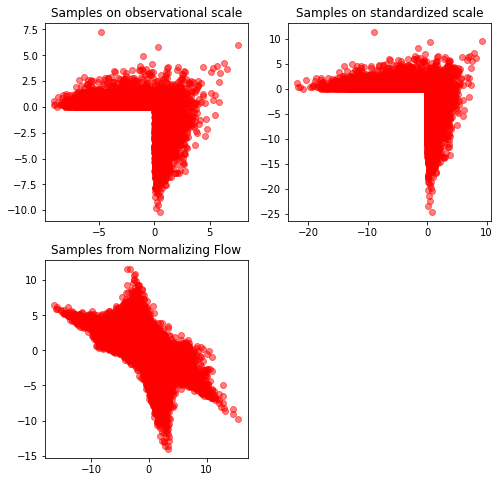

Epoch 55/100, Loss: 0.4976
Epoch 54 - Learning Rate: 0.00021866669160892403


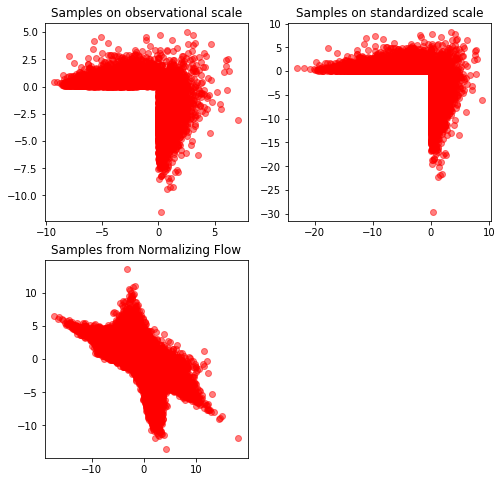

Epoch 56/100, Loss: 0.4978
Epoch 55 - Learning Rate: 0.00021089138373994235


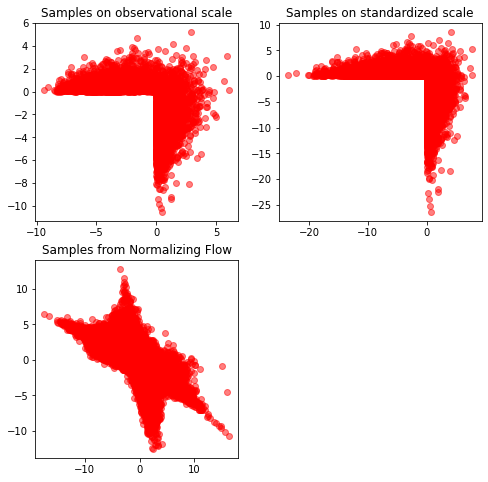

Epoch 57/100, Loss: 0.4978
Epoch 56 - Learning Rate: 0.00020315467135356892


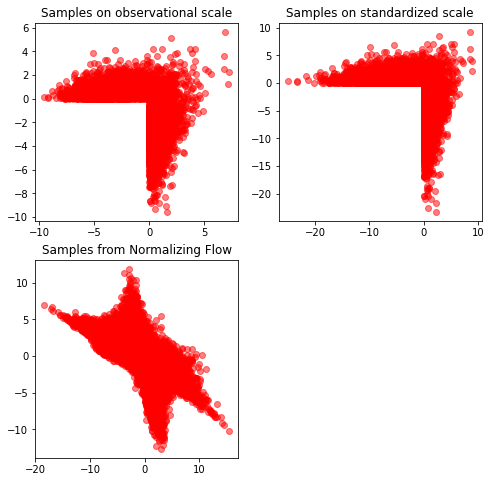

Epoch 58/100, Loss: 0.4975
Epoch 57 - Learning Rate: 0.0001954641896508645


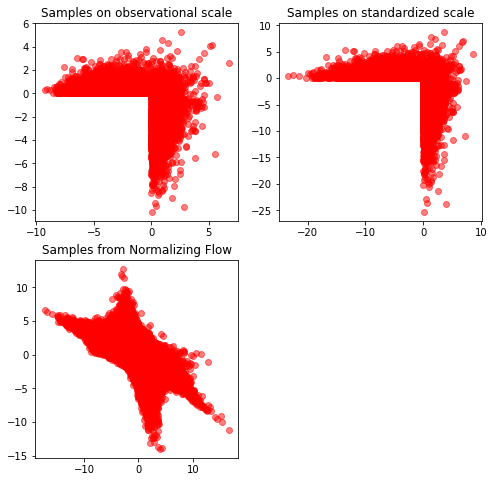

Epoch 59/100, Loss: 0.4969
Epoch 58 - Learning Rate: 0.00018782752820878634


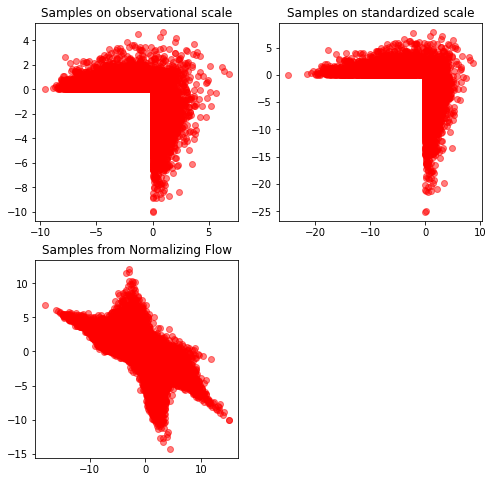

Epoch 60/100, Loss: 0.4970
Epoch 59 - Learning Rate: 0.00018025222349019276


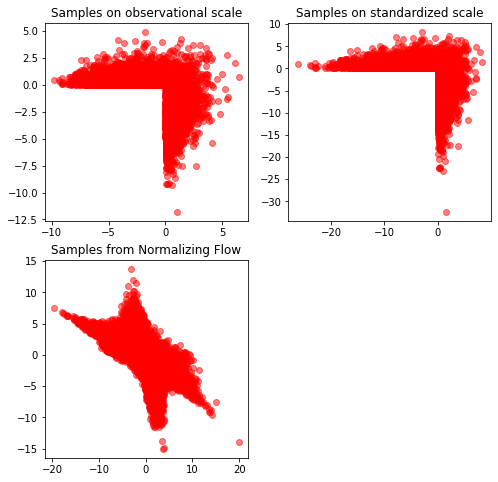

Epoch 61/100, Loss: 0.4954
Epoch 60 - Learning Rate: 0.00017274575140626327


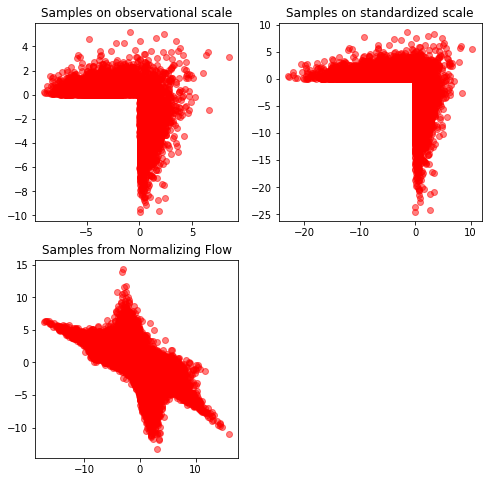

Epoch 62/100, Loss: 0.4976
Epoch 61 - Learning Rate: 0.0001653155199386772


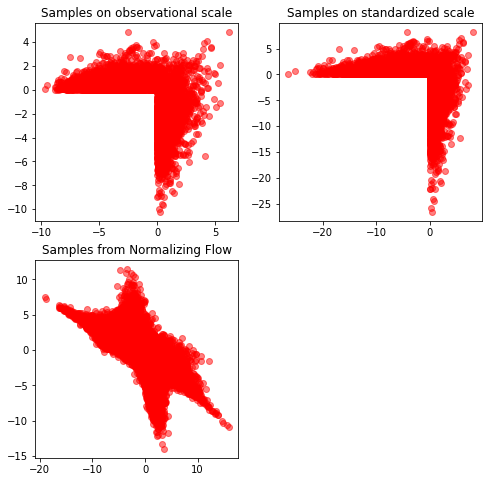

Epoch 63/100, Loss: 0.4956
Epoch 62 - Learning Rate: 0.00015796886182883063


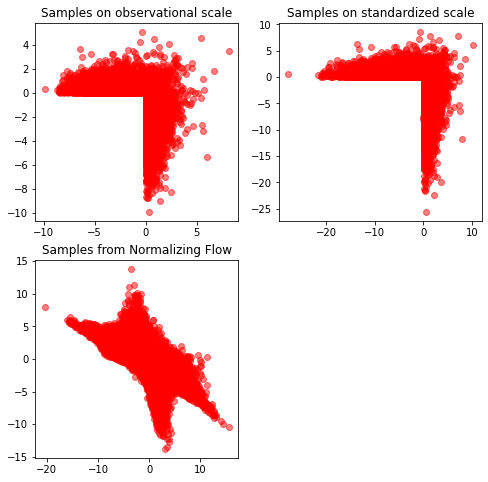

Epoch 64/100, Loss: 0.4957
Epoch 63 - Learning Rate: 0.00015071302734130486


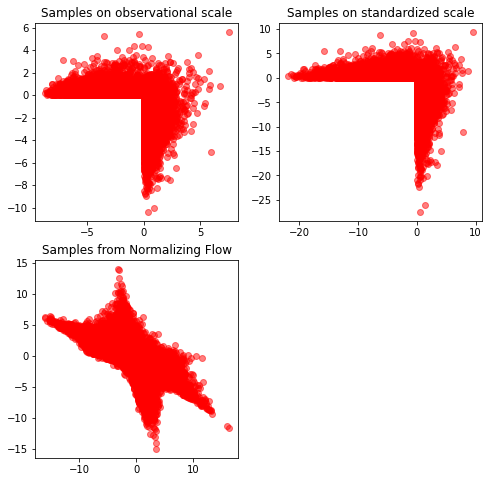

Epoch 65/100, Loss: 0.4954
Epoch 64 - Learning Rate: 0.00014355517710873186


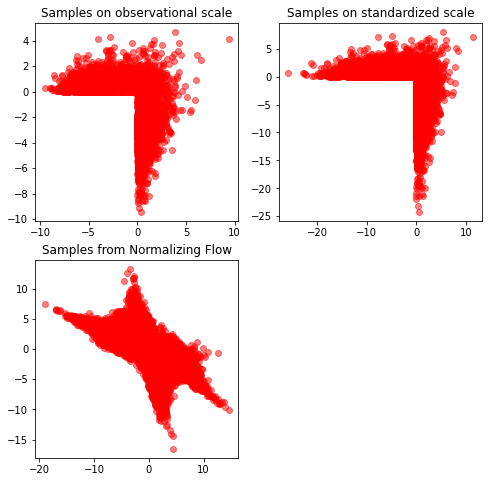

Epoch 66/100, Loss: 0.4951
Epoch 65 - Learning Rate: 0.00013650237506511334


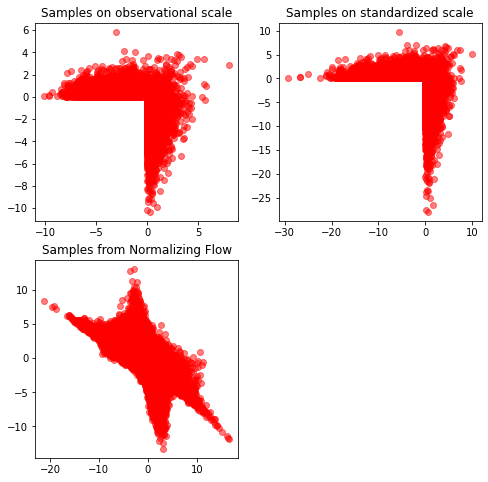

Epoch 67/100, Loss: 0.4949
Epoch 66 - Learning Rate: 0.00012956158147457117


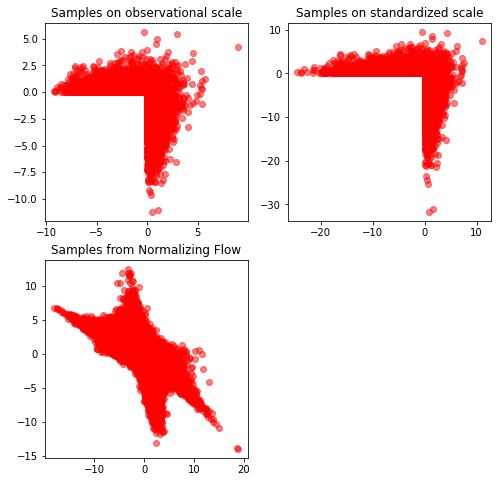

Epoch 68/100, Loss: 0.4957
Epoch 67 - Learning Rate: 0.0001227396460624072


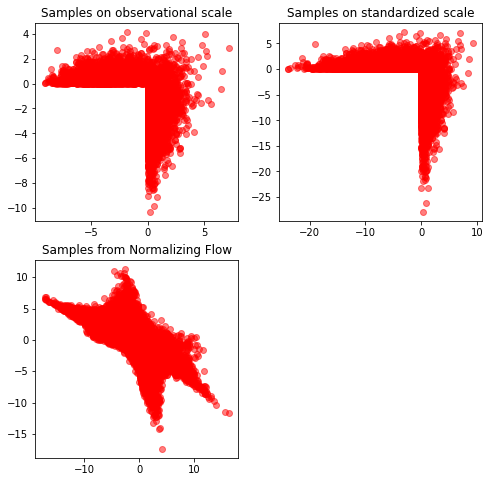

Epoch 69/100, Loss: 0.4955
Epoch 68 - Learning Rate: 0.00011604330125525082


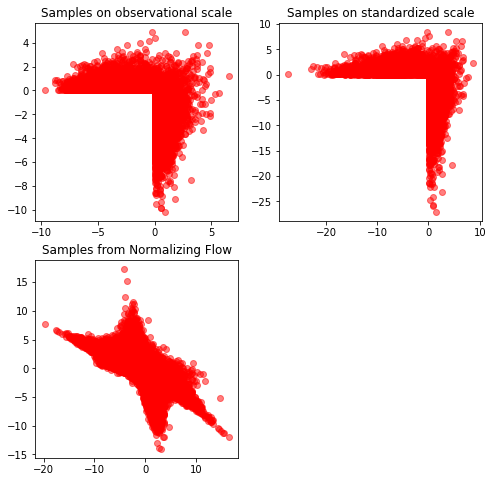

Epoch 70/100, Loss: 0.4941
Epoch 69 - Learning Rate: 0.00010947915553696737


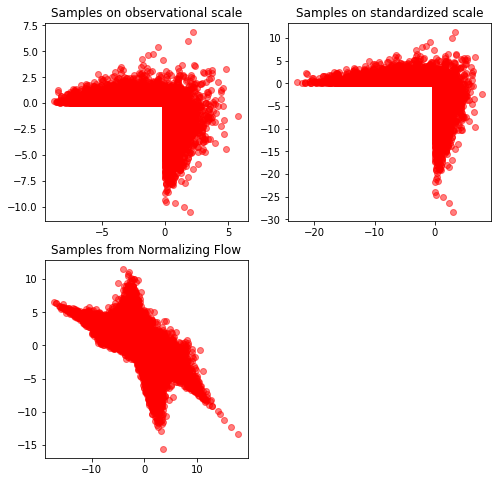

Epoch 71/100, Loss: 0.4953
Epoch 70 - Learning Rate: 0.00010305368692688178


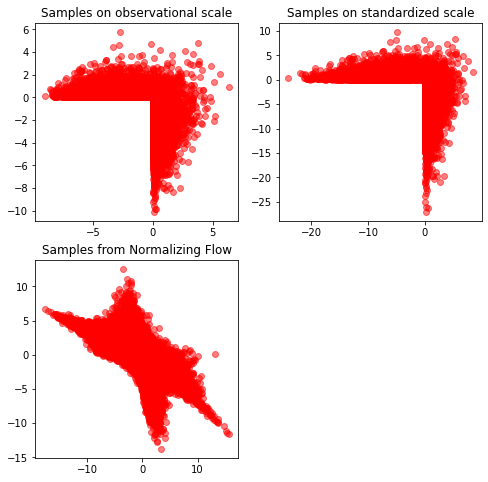

Epoch 72/100, Loss: 0.4959
Epoch 71 - Learning Rate: 9.677323658675589e-05


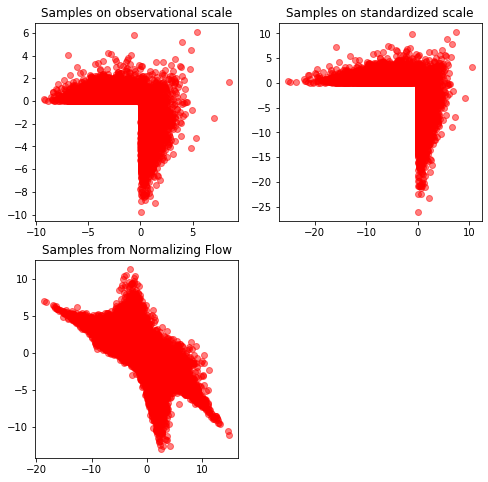

Epoch 73/100, Loss: 0.4951
Epoch 72 - Learning Rate: 9.06440025628276e-05


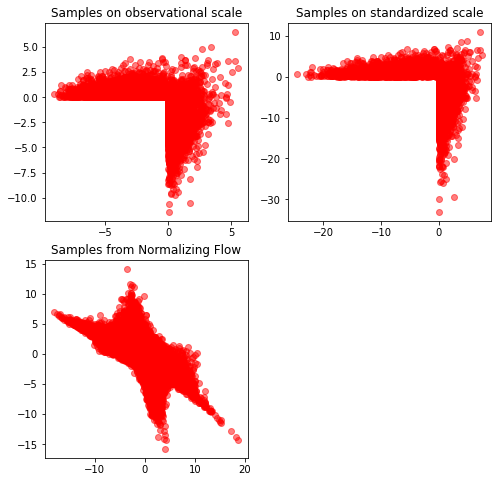

Epoch 74/100, Loss: 0.4957
Epoch 73 - Learning Rate: 8.467203366908711e-05


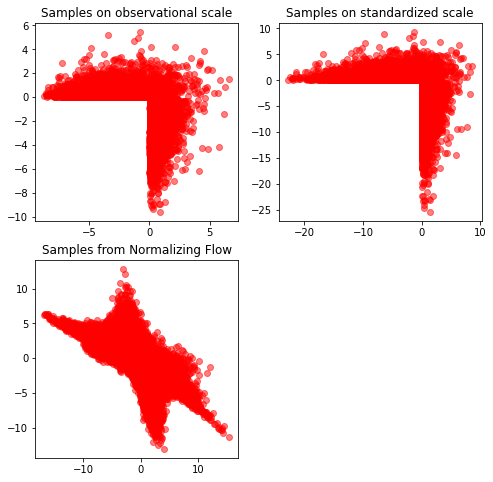

Epoch 75/100, Loss: 0.4962
Epoch 74 - Learning Rate: 7.886322351782786e-05


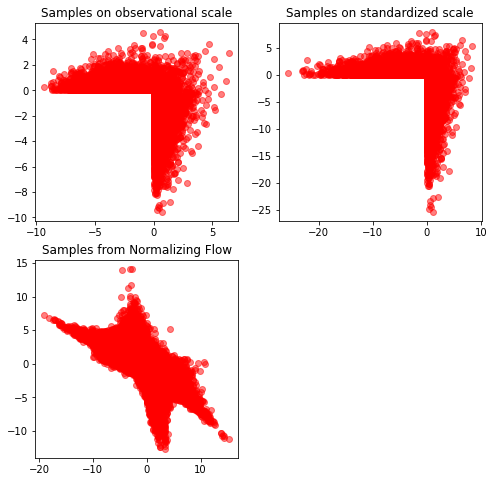

Epoch 76/100, Loss: 0.4949
Epoch 75 - Learning Rate: 7.322330470336317e-05


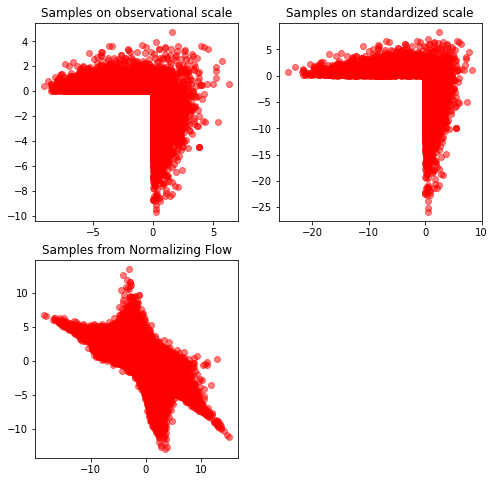

Epoch 77/100, Loss: 0.4936
Epoch 76 - Learning Rate: 6.77578431446472e-05


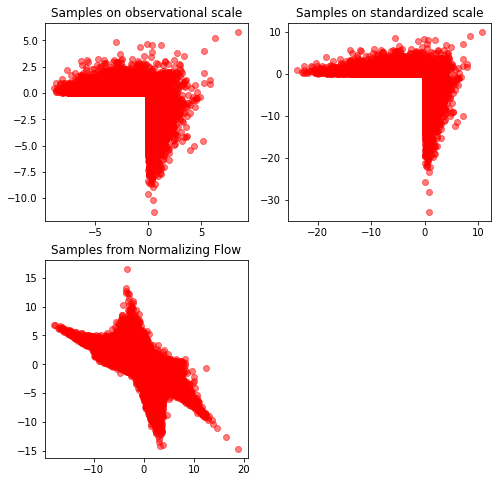

Epoch 78/100, Loss: 0.4945
Epoch 77 - Learning Rate: 6.247223259238512e-05


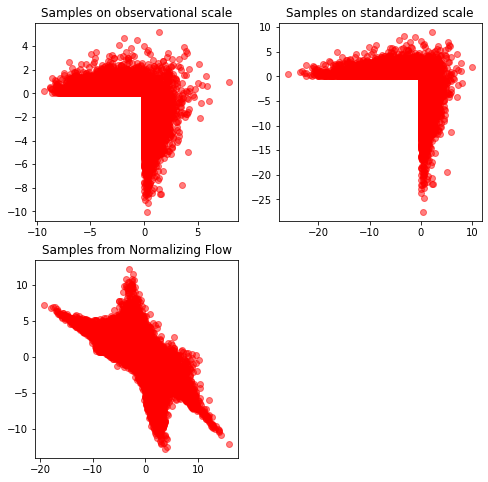

Epoch 79/100, Loss: 0.4952
Epoch 78 - Learning Rate: 5.737168930605274e-05


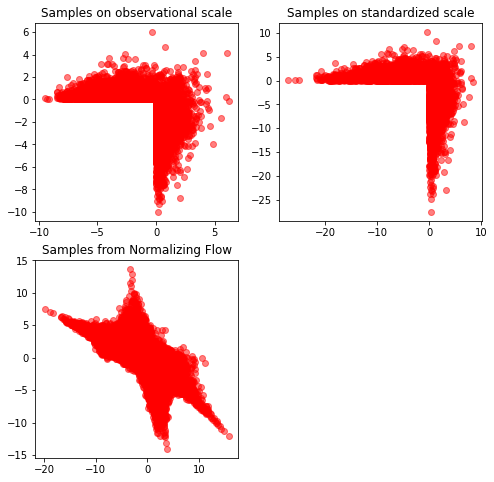

Epoch 80/100, Loss: 0.4950
Epoch 79 - Learning Rate: 5.2461246906077416e-05


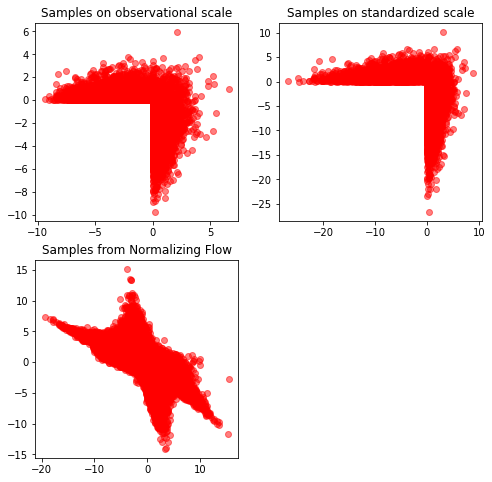

Epoch 81/100, Loss: 0.4949
Epoch 80 - Learning Rate: 4.7745751406263184e-05


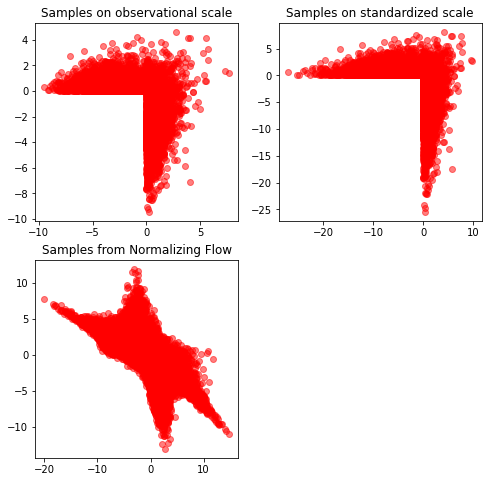

Epoch 82/100, Loss: 0.4927
Epoch 81 - Learning Rate: 4.322985643135959e-05


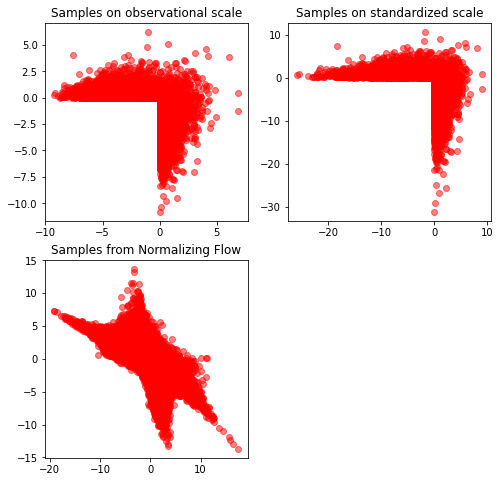

Epoch 83/100, Loss: 0.4952
Epoch 82 - Learning Rate: 3.89180186244963e-05


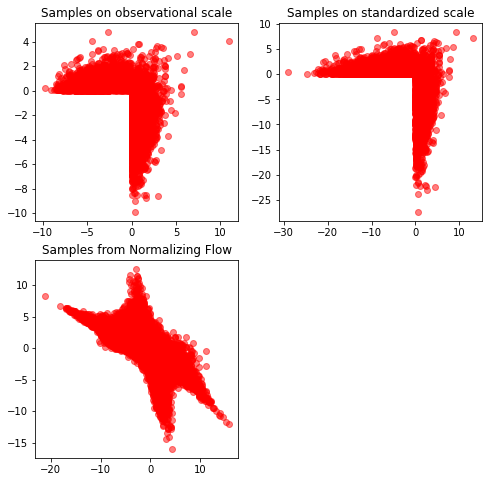

Epoch 84/100, Loss: 0.4938
Epoch 83 - Learning Rate: 3.481449324901408e-05


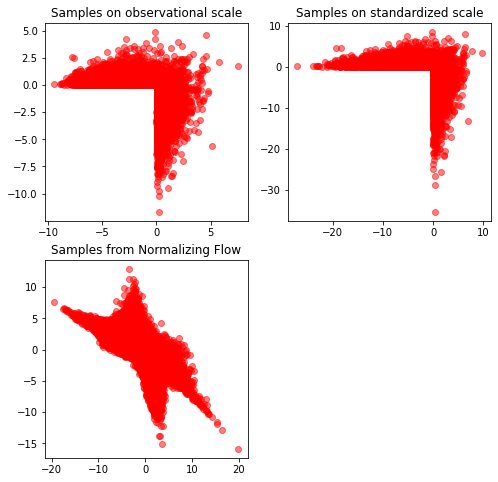

Epoch 85/100, Loss: 0.4939
Epoch 84 - Learning Rate: 3.092332998903412e-05


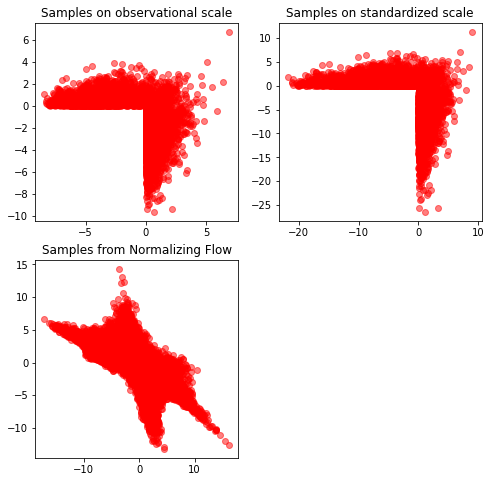

Epoch 86/100, Loss: 0.4936
Epoch 85 - Learning Rate: 2.7248368952908065e-05


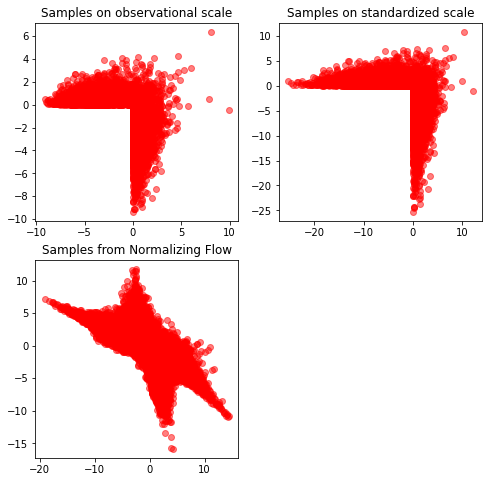

Epoch 87/100, Loss: 0.4958
Epoch 86 - Learning Rate: 2.379323688349517e-05


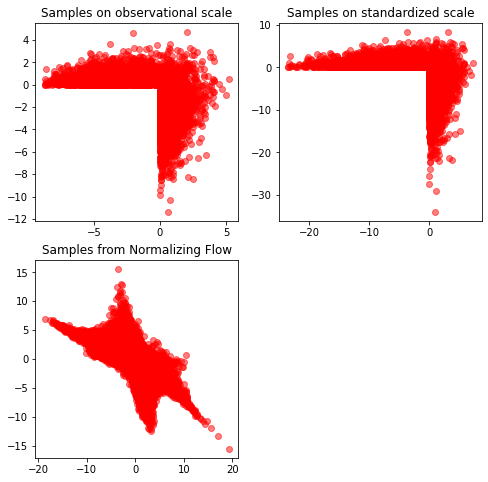

Epoch 88/100, Loss: 0.4948
Epoch 87 - Learning Rate: 2.056134357900478e-05


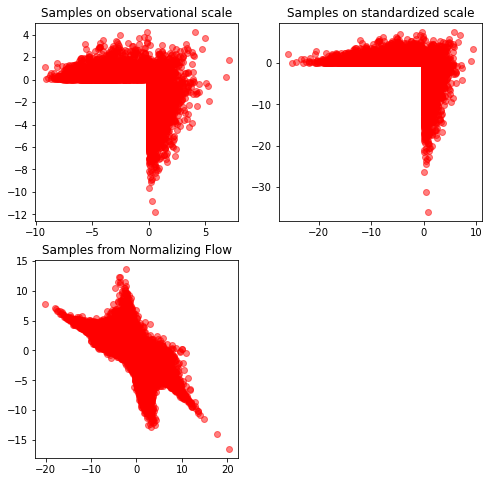

Epoch 89/100, Loss: 0.4934
Epoch 88 - Learning Rate: 1.755587852793717e-05


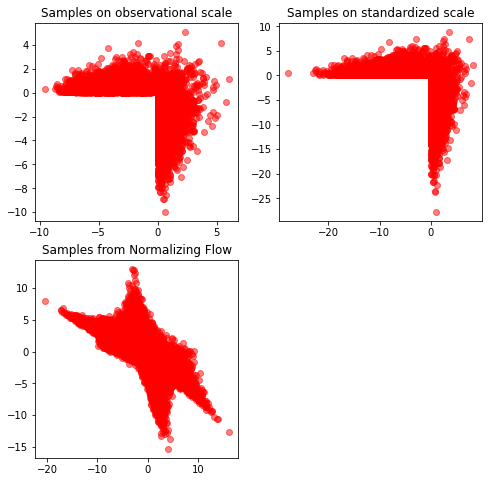

Epoch 90/100, Loss: 0.4941
Epoch 89 - Learning Rate: 1.4779807761443642e-05


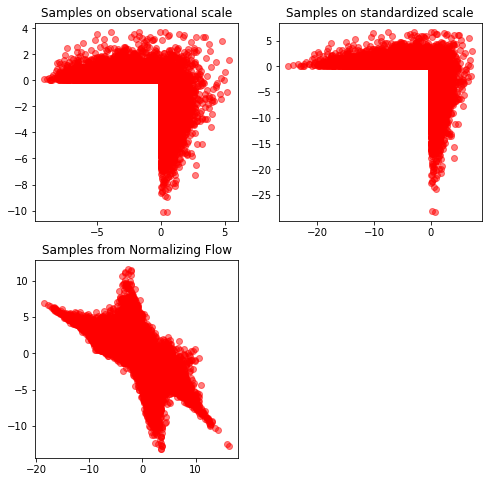

Epoch 91/100, Loss: 0.4927
Epoch 90 - Learning Rate: 1.223587092621162e-05


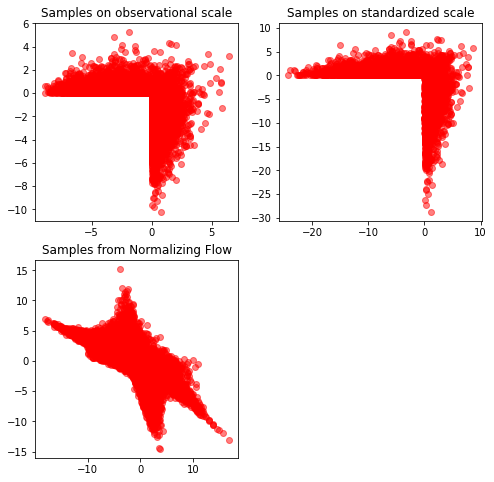

Epoch 92/100, Loss: 0.4927
Epoch 91 - Learning Rate: 9.926578580764263e-06


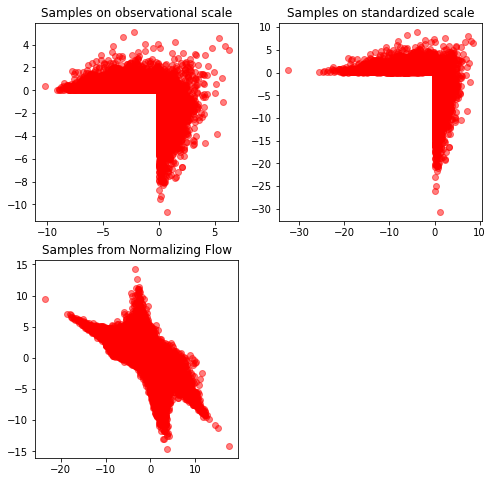

Epoch 93/100, Loss: 0.4952
Epoch 92 - Learning Rate: 7.85420971784226e-06


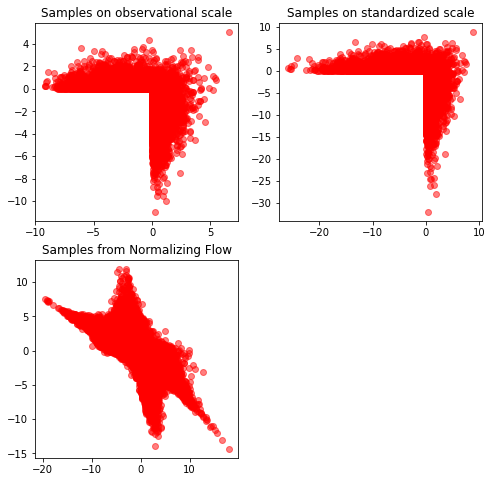

Epoch 94/100, Loss: 0.4918
Epoch 93 - Learning Rate: 6.02080951531317e-06


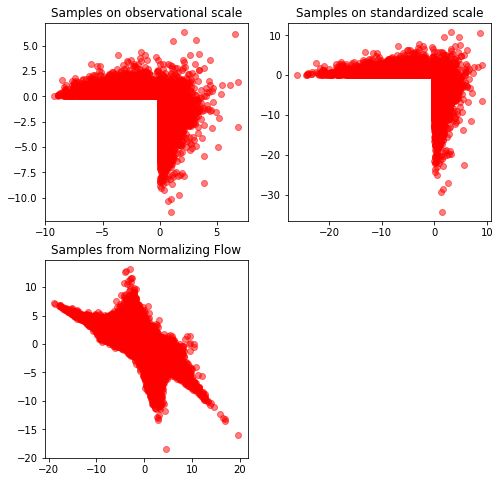

Epoch 95/100, Loss: 0.4946
Epoch 94 - Learning Rate: 4.42818731782782e-06


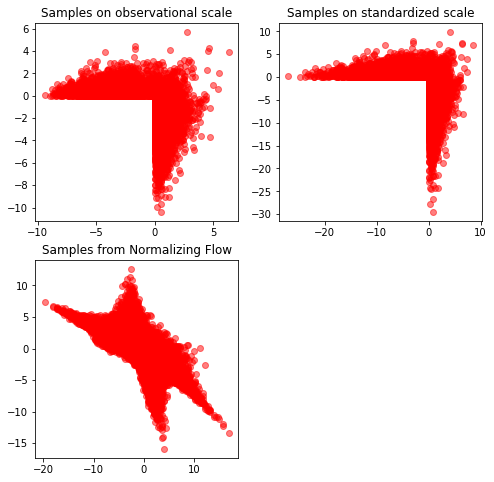

Epoch 96/100, Loss: 0.4955
Epoch 95 - Learning Rate: 3.0779148512155855e-06


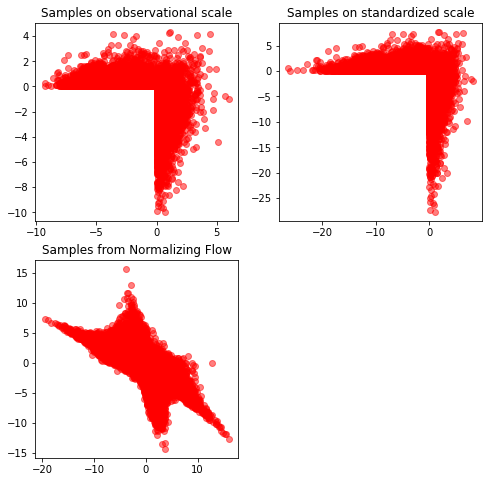

Epoch 97/100, Loss: 0.4941
Epoch 96 - Learning Rate: 1.971324671380559e-06


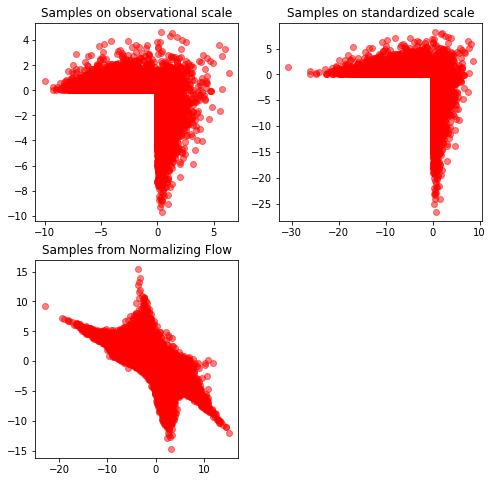

Epoch 98/100, Loss: 0.4929
Epoch 97 - Learning Rate: 1.1095088492300012e-06


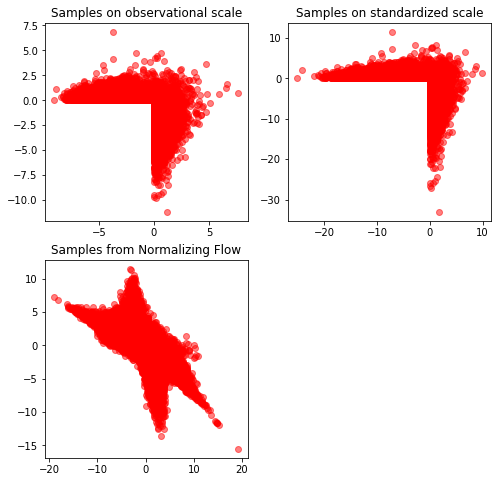

Epoch 99/100, Loss: 0.4954
Epoch 98 - Learning Rate: 4.933178929321103e-07


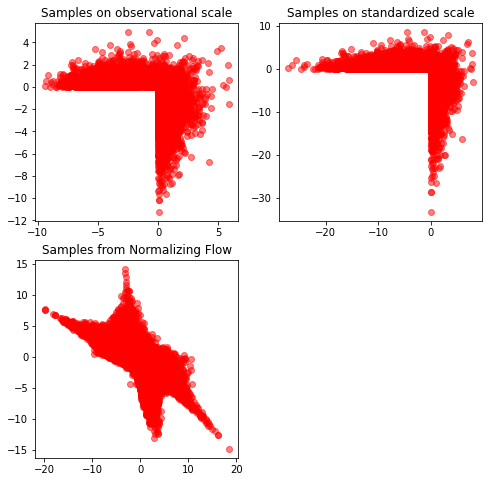

Epoch 100/100, Loss: 0.4946
Epoch 99 - Learning Rate: 1.233599085671e-07


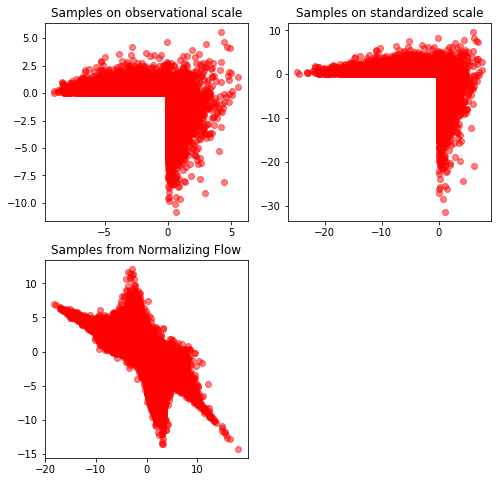

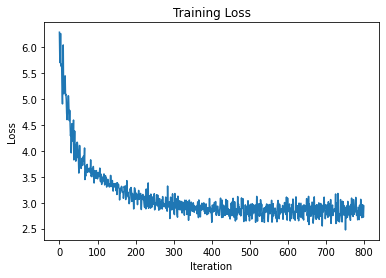

In [88]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=10, verbose=True
# )

seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

Training_Data = DataLoader(data, batch_size=batch_size, shuffle=True)
for epoch in range(epochs):
    epoch_loss = 0.0
    
    for x_data in Training_Data:
        # Sample a batch of data from h_U

        batch_loss = model(x_data)

        # Backpropagation
        optimizer.zero_grad()
        batch_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)


        optimizer.step()

        # Record loss
        loss_history.append(batch_loss.item())
        epoch_loss += batch_loss.item()

        if torch.isnan(batch_loss) or torch.isinf(batch_loss):
            print("NaN or Inf detected!")
            break

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(x_data):.4f}")
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch} - Learning Rate: {current_lr}")
    # Debugging: Print shapes

    samples_obs, samples_std, samples_T= model.sample(n_samples)

    samples_obs, samples_std, samples_T= model.sample(n_samples)
    plt.figure(figsize=(8,8))
    plt.subplot(2, 2, 1)
    plt.scatter(samples_obs[:,0].cpu().data.numpy(), samples_obs[:,1].cpu().data.numpy(), alpha=0.5, color='red')
    plt.title('Samples on observational scale')
    plt.subplot(2, 2, 2)
    plt.scatter(samples_std[:,0].cpu().data.numpy(), samples_std[:,1].cpu().data.numpy(), alpha=0.5, color='red')
    plt.title('Samples on standardized scale')
    plt.subplot(2, 2, 3)
    plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=0.5, color='red')
    plt.title('Samples from Normalizing Flow')
    plt.show()

    scheduler.step()
    
# Plot the training loss
plt.figure()
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [89]:
print(model.data_transform.get_sigma())
print(model.data_transform.get_gamma())

tensor([0.6124, 0.5073], device='cuda:0', grad_fn=<ClampBackward1>)
tensor([0.0465, 0.0265], device='cuda:0', grad_fn=<MulBackward0>)


In [78]:
print(model.data_transform.get_sigma())
print(model.data_transform.get_gamma())

tensor([0.6260, 0.4640], device='cuda:0', grad_fn=<ClampBackward1>)
tensor([0.0471, 0.0345], device='cuda:0', grad_fn=<MulBackward0>)


In [55]:
np.log(20.7313)

3.0316446355282247

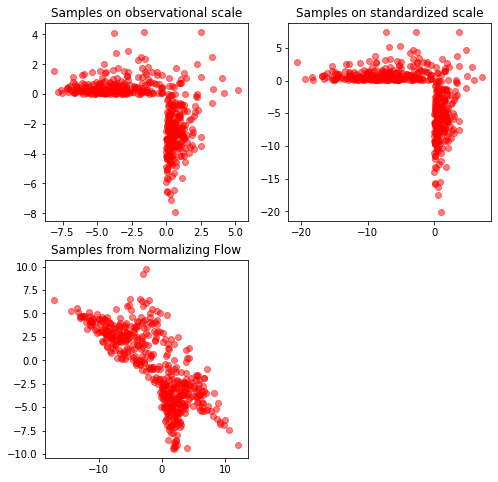

In [94]:
samples_obs, samples_std, samples_T= model.sample(500)
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.scatter(samples_obs[:,0].cpu().data.numpy(), samples_obs[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples on observational scale')
plt.subplot(2, 2, 2)
plt.scatter(samples_std[:,0].cpu().data.numpy(), samples_std[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples on standardized scale')
plt.subplot(2, 2, 3)
plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples from Normalizing Flow')
plt.show()

In [ ]:
np.mean(abs(samples_T[:,0].cpu().data.numpy() - samples_T[:,1].cpu().data.numpy()))

/tmp/ipykernel_314474/2014099692.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples[:,0], hist=False, kde=True,
/tmp/ipykernel_314474/2014099692.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples_obs[:,0].cpu().data.numpy(), hist=False, kde=True,
/tmp/ipykerne

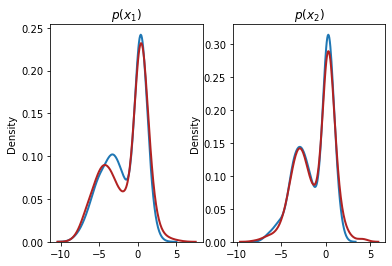

In [95]:
plt.subplot(1, 2, 1)
sns.distplot(samples[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(samples_obs[:,0].cpu().data.numpy(), hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(samples[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(samples_obs[:,1].cpu().data.numpy(), hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

/tmp/ipykernel_314474/2863656582.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples[:,1], hist=False, kde=True,


<Axes: ylabel='Density'>

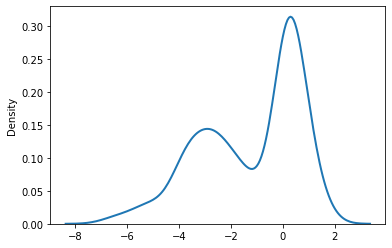

In [70]:
sns.distplot(samples[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')

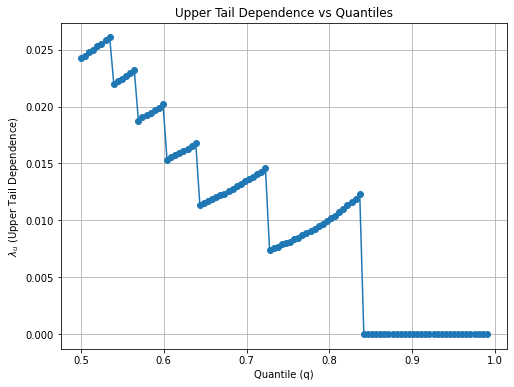

Empirical upper tail dependence: 0.0


In [92]:
def empirical_upper_tail_dependence(X1, X2, q):
    """
    Calculate empirical upper tail dependence coefficient.

    Parameters:
    X1, X2 : numpy arrays
        Samples from two random variables.
    q : float
        Quantile threshold (close to 1, e.g., 0.95 or 0.99).

    Returns:
    lambda_u : float
        Empirical upper tail dependence coefficient.
    """
    # Compute the quantiles
    F1_q = np.quantile(X1, q)
    F2_q = np.quantile(X2, q)
    
    # Count joint exceedances
    joint_exceedance = np.sum((X1 > F1_q) & (X2 > F2_q))
    exceedance_X1 = np.sum(X1 > F1_q)
    
    # Calculate lambda_u
    if exceedance_X1 == 0:  # Avoid division by zero
        return 0.0
    lambda_u = joint_exceedance / exceedance_X1
    return lambda_u


def plot_tail_dependence(X1, X2, quantiles):
    """
    Plot upper tail dependence vs quantiles.

    Parameters:
    X1, X2 : numpy arrays
        Samples from two random variables.
    quantiles : list or array
        List of quantiles to evaluate (e.g., np.linspace(0.9, 0.99, 50)).
    """
    # Compute lambda_u for each quantile
    lambda_values = [empirical_upper_tail_dependence(X1, X2, q) for q in quantiles]
    
    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.plot(quantiles, lambda_values, marker='o', linestyle='-')
    plt.xlabel('Quantile (q)')
    plt.ylabel(r'$\lambda_u$ (Upper Tail Dependence)')
    plt.title('Upper Tail Dependence vs Quantiles')
    plt.grid(True)
    plt.show()

# Example usage
np.random.seed(42)
X1 = samples[:,0]
X2 = samples[:,1]

# Define quantiles (e.g., from 0.90 to 0.99)
quantiles = np.linspace(0.50, 0.990, 100)

# Plot the tail dependence
plot_tail_dependence(X1, X2, quantiles)
# Compute lambda_u at 0.95 quantile
q = 0.99
lambda_u = empirical_upper_tail_dependence(X1, X2, q)
print(f"Empirical upper tail dependence: {lambda_u}")

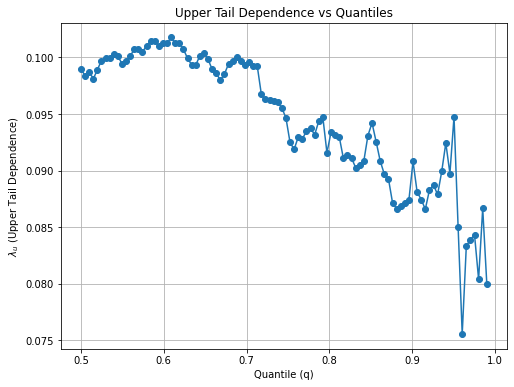

Empirical upper tail dependence: 0.08


In [93]:
X1 = samples_obs[:,0].cpu().data.numpy()
X2 = samples_obs[:,1].cpu().data.numpy()

# Define quantiles (e.g., from 0.90 to 0.99)
quantiles = np.linspace(0.50, 0.990, 100)

# Plot the tail dependence
plot_tail_dependence(X1, X2, quantiles)
# Compute lambda_u at 0.95 quantile
q = 0.99
lambda_u = empirical_upper_tail_dependence(X1, X2, q)
print(f"Empirical upper tail dependence: {lambda_u}")

In [130]:
X1 = samples_obs[:,0].cpu().data.numpy()
X2 = samples_obs[:,1].cpu().data.numpy()
chi = []
for i in range(100):
    samples_obs, samples_std, samples_T= model.sample(10000)
    X1 = samples_obs[:,0].cpu().data.numpy()
    X2 = samples_obs[:,1].cpu().data.numpy()
    chi.append(empirical_upper_tail_dependence(X1,X2,0.99))

/tmp/ipykernel_4165448/1578080669.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(chi, hist=False, kde=True,


<Axes: ylabel='Density'>

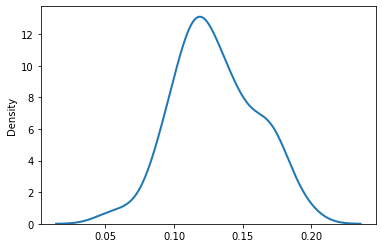

In [131]:
sns.distplot(chi, hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')

In [97]:
nf.flows.Permute?